<a href="https://colab.research.google.com/github/probml/dynamax/blob/main/dynamax/generalized_gaussian_ssm/dekf/demos/diagonal_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demos of Diagonal Approximations of EKF

# 0. Imports

In [1]:
try:
    from dynamax.generalized_gaussian_ssm.inference import *
    from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
    import chex
    import flax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq dynamax
    print('installing chex')
    %pip install chex
    print('installing flax')
    %pip install flax
    from dynamax.generalized_gaussian_ssm.inference import *
    from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
    import chex
    import flax

2022-12-09 11:57:41.410847: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-12-09 11:57:42.264250: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-12-09 11:57:42.264352: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-12-09 11:57:42.264361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use

In [2]:
from typing import Sequence
from functools import partial

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
from jax import jacfwd
from jax import vmap
from jax import jit
from jax.tree_util import tree_map, tree_reduce
import flax.linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
import chex
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.flatten_util import ravel_pytree
import optax
from dynamax.generalized_gaussian_ssm.dekf.diagonal_inference import (
    DEKFParams,
    _stationary_dynamics_diagonal_predict,
    _fully_decoupled_ekf_condition_on,
    stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter,
    _variational_diagonal_ekf_condition_on,
    stationary_dynamics_variational_diagonal_extended_kalman_filter,
    _jacrev_2d,
)
from sklearn import datasets
from sklearn import preprocessing

# 1. MLP Definition

In [3]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    """Generate MLP model, initialize it using dummy input, and
    return the model, its flattened initial parameters, function
    to unflatten parameters, and apply function for the model.
    Args:
        model_dims (List): List of [input_dim, hidden_dim, ..., output_dim]
        key (PRNGKey): Random key. Defaults to 0.
    Returns:
        model: MLP model with given feature dimensions.
        flat_params: Flattened parameters initialized using dummy input.
        unflatten_fn: Function to unflatten parameters.
        apply_fn: fn(flat_params, x) that returns the result of applying the model.
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

# 2. Demo - Linear Regression

## 2.1 Dataset Generation

In [4]:
def generate_linreg_dataset(num_points=100, theta=jnp.array([1, 0.5]), var=0.1, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = theta[1]*X + theta[0]
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]

    return X, X_sh, Y, Y_sh, Y_tr

In [5]:
# 100 data points
X_lr_100, X_lr_100_sh, Y_lr_100, Y_lr_100_sh, Y_lr_100_tr = generate_linreg_dataset()

# 200 data points
X_lr_200, X_lr_200_sh, Y_lr_200, Y_lr_200_sh, Y_lr_200_tr = generate_linreg_dataset(200)

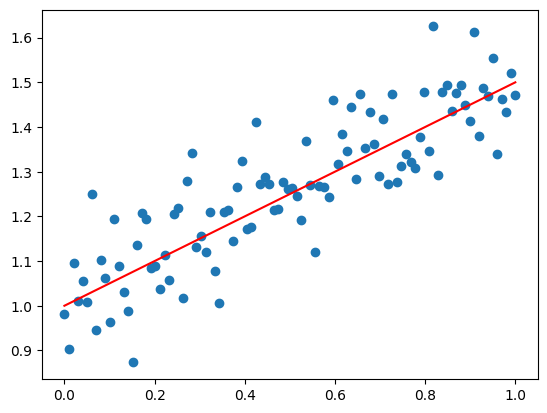

In [6]:
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, Y_lr_100_tr, c='red');

In [7]:
# Define Linear Regression as single layer perceptron
input_dim_lr, hidden_dims_lr, output_dim_lr = 1, [], 1
model_dims_lr = [input_dim_lr, *hidden_dims_lr, output_dim_lr]
_, flat_params_lr, _, apply_fn_lr = get_mlp_flattened_params(model_dims_lr)
print(flat_params_lr.shape)

(2,)


## 2.2 Full-Covariance CMGF-EKF

In [8]:
# FC-EKF for linear regression
state_dim_lr, emission_dim_lr = flat_params_lr.size, output_dim_lr
var_lr = 0.1
fcekf_params_lr = ParamsGGSSM(
    initial_mean=flat_params_lr,
    initial_covariance=jnp.eye(state_dim_lr),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_lr) * 0,
    emission_mean_function = lambda w, x: apply_fn_lr(w, x),
    emission_cov_function = lambda w, x: var_lr
)
v_apply_fn_lr = vmap(apply_fn_lr, (None, 0))

fcekf_theta_lr_100 = [1.0154611 0.4900458]


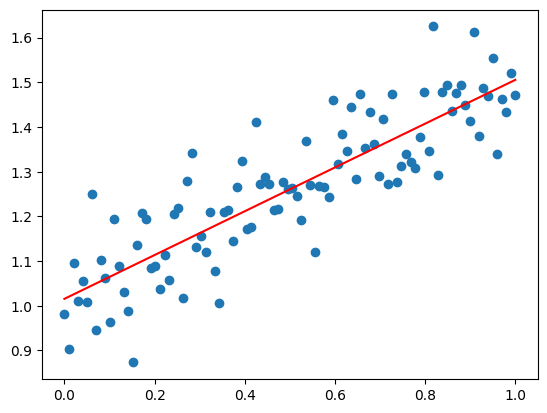

In [9]:
# 100 datapoints
fcekf_post_lr_100 = conditional_moments_gaussian_filter(fcekf_params_lr, EKFIntegrals(), Y_lr_100_sh, inputs=X_lr_100_sh)
fcekf_theta_lr_100 = fcekf_post_lr_100.filtered_means[-1]
print(f'fcekf_theta_lr_100 = {fcekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(fcekf_theta_lr_100, X_lr_100), c='red');

fcekf_theta_lr_200 = [1.0101917  0.48369375]


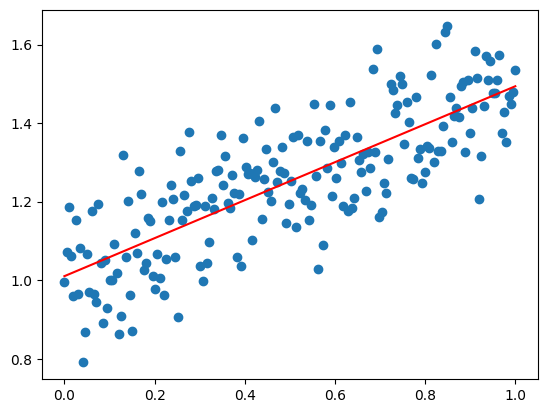

In [10]:
# 200 datapoints
fcekf_post_lr_200 = conditional_moments_gaussian_filter(fcekf_params_lr, EKFIntegrals(), Y_lr_200_sh, inputs=X_lr_200_sh)
fcekf_theta_lr_200 = fcekf_post_lr_200.filtered_means[-1]
print(f'fcekf_theta_lr_200 = {fcekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(fcekf_theta_lr_200, X_lr_200), c='red');

## 2.3 Fully-Decoupled Diagonal EKF

In [11]:
# D-EKF for linear regression
dekf_params_lr = DEKFParams(
    initial_mean=flat_params_lr,
    initial_cov_diag=jnp.ones((state_dim_lr,)),
    dynamics_cov_diag=jnp.ones((state_dim_lr,)) * 0,
    emission_mean_function = lambda w, x: apply_fn_lr(w, x),
    emission_cov_function = lambda w, x: var_lr
)

fdekf_theta_lr_100 = [1.0655403 0.4243414]


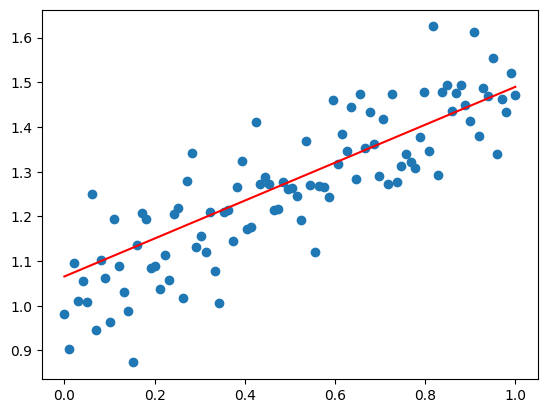

In [12]:
# 100 datapoints
fdekf_post_lr_100 = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_lr, Y_lr_100, inputs=X_lr_100)
fdekf_theta_lr_100 = fdekf_post_lr_100.filtered_means[-1]
print(f'fdekf_theta_lr_100 = {fdekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(fdekf_theta_lr_100, X_lr_100), c='red');

fdekf_theta_lr_200 = [1.0710163  0.40271807]


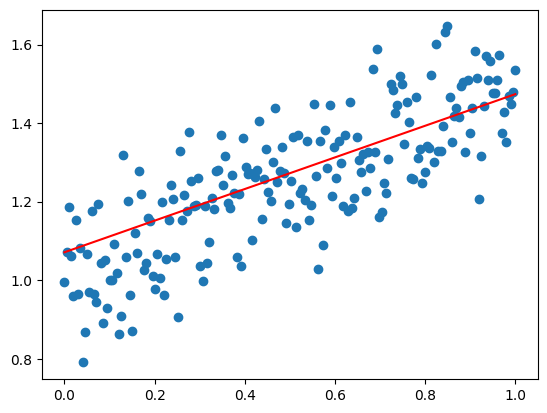

In [13]:
# 200 datapoints
fdekf_post_lr_200 = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_lr, Y_lr_200, inputs=X_lr_200)
fdekf_theta_lr_200 = fdekf_post_lr_200.filtered_means[-1]
print(f'fdekf_theta_lr_200 = {fdekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(fdekf_theta_lr_200, X_lr_200), c='red');

## 2.4 Variational Diagonal EKF

vdekf_theta_lr_100 = [1.0622965 0.4284295]


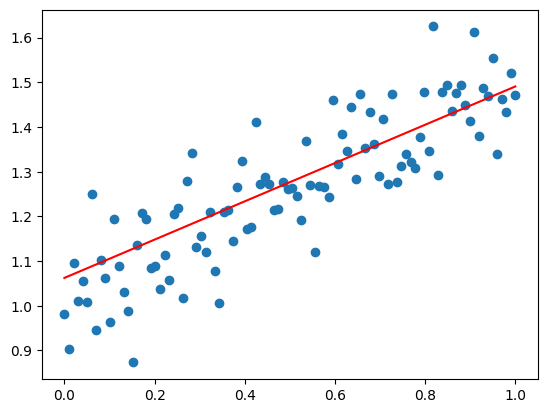

In [14]:
# 100 datapoints
vdekf_post_lr_100 = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_lr, Y_lr_100, inputs=X_lr_100)
vdekf_theta_lr_100 = vdekf_post_lr_100.filtered_means[-1]
print(f'vdekf_theta_lr_100 = {vdekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(vdekf_theta_lr_100, X_lr_100), c='red');

vdekf_theta_lr_200 = [1.0714712 0.4020149]


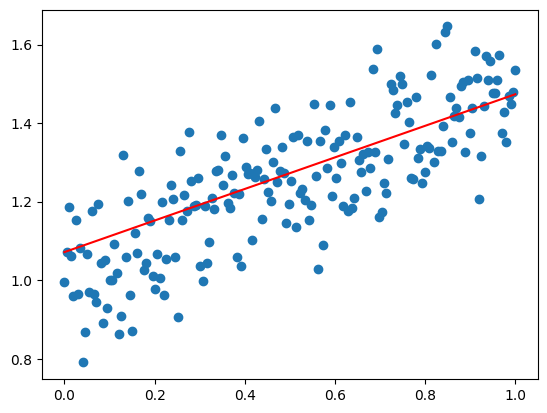

In [15]:
# 200 datapoints
vdekf_post_lr_200 = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_lr, Y_lr_200, inputs=X_lr_200)
vdekf_theta_lr_200 = vdekf_post_lr_200.filtered_means[-1]
print(f'vdekf_theta_lr_200 = {vdekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(vdekf_theta_lr_200, X_lr_200), c='red');

## 2.5 SGD - Single Pass

In [16]:
# Generic loss function
def loss_optax(params, x, y, loss_fn, apply_fn):
    y, y_hat = jnp.atleast_1d(y), apply_fn(params, x)
    loss_value = loss_fn(y, y_hat)
    return loss_value.mean()

In [17]:
# SGD fit function
def fit_optax(params, optimizer, input, output, loss_fn, num_epochs=200):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, x, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(zip(input, output)):
            params, opt_state, loss_value = step(params, opt_state, x, y)
    
    return params

# Define SGD optimizer
sgd_optimizer = optax.sgd(learning_rate=1e-2)

In [18]:
# L2 loss function for linear regression
loss_fn_lr = partial(loss_optax, loss_fn = optax.l2_loss, apply_fn = apply_fn_lr)

sgd_sp_theta_lr_100 = [0.7841333  0.24538857]


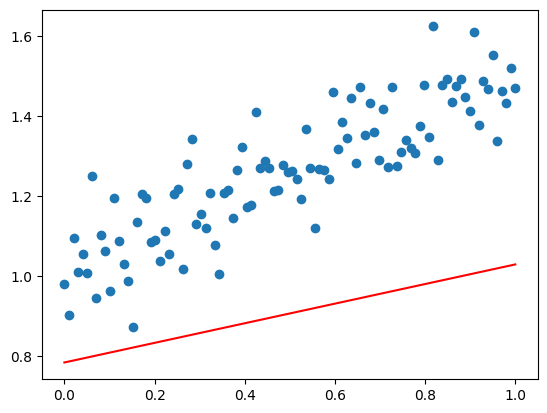

In [19]:
# 100 datapoints
sgd_sp_theta_lr_100 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_100, Y_lr_100, loss_fn_lr, num_epochs=1)
print(f'sgd_sp_theta_lr_100 = {sgd_sp_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(sgd_sp_theta_lr_100, X_lr_100), c='red');

sgd_sp_theta_lr_100 = [1.0464455  0.28148997]


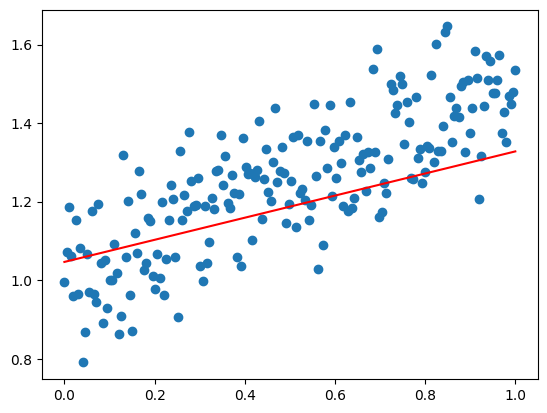

In [20]:
# 200 datapoints
sgd_sp_theta_lr_200 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_200, Y_lr_200, loss_fn_lr, num_epochs=1)
print(f'sgd_sp_theta_lr_100 = {sgd_sp_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(sgd_sp_theta_lr_200, X_lr_200), c='red');

## 2.6 SGD - Multi Pass (200 Epochs)

sgd_mp_theta_lr_100 = [1.0177526 0.4867086]


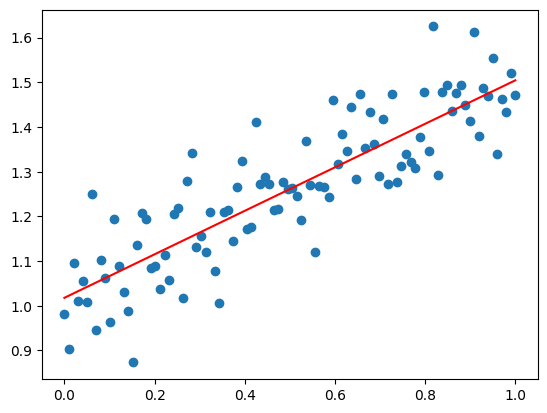

In [21]:
# 100 datapoints
sgd_mp_theta_lr_100 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_100, Y_lr_100, loss_fn_lr)
print(f'sgd_mp_theta_lr_100 = {sgd_mp_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(sgd_mp_theta_lr_100, X_lr_100), c='red');

sgd_mp_theta_lr_200 = [1.0130821 0.477784 ]


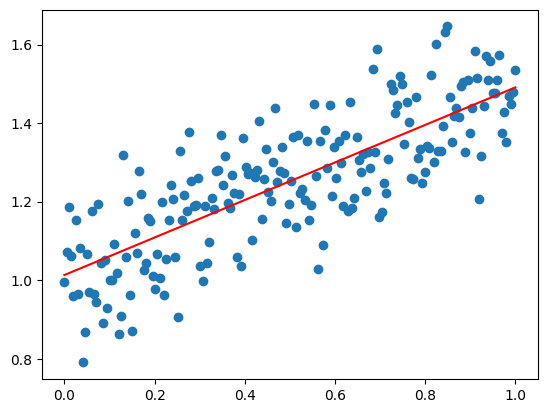

In [22]:
# 200 datapoints
sgd_mp_theta_lr_200 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_200, Y_lr_200, loss_fn_lr)
print(f'sgd_mp_theta_lr_200 = {sgd_mp_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(sgd_mp_theta_lr_200, X_lr_200), c='red');

# 3. Demo - Nonlinear Regression

## 3.1 Dataset Generation

In [23]:
def generate_nonlinreg_dataset(num_points=400, fn=lambda x: jnp.sin(5*x**2 - 1), var=0.1, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = vmap(fn)(X)
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]
    return X, X_sh, Y, Y_sh, Y_tr

In [24]:
X_nr, X_nr_sh, Y_nr, Y_nr_sh, Y_nr_tr = generate_nonlinreg_dataset()

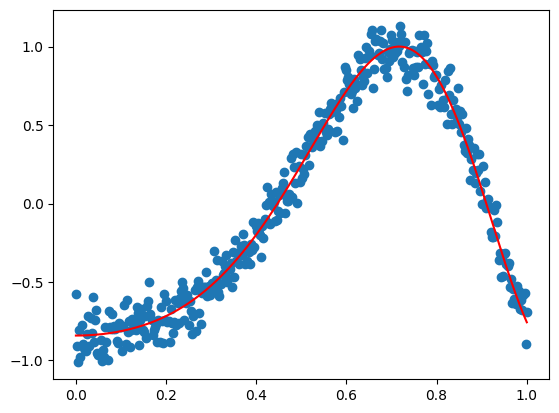

In [25]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, Y_nr_tr, c='red');

In [26]:
# Define Linear Regression as MLP with one hidden layer
input_dim_nr, hidden_dims_nr, output_dim_nr = 1, [15, 15], 1
model_dims_nr = [input_dim_nr, *hidden_dims_nr, output_dim_nr]
_, flat_params_nr, _, apply_fn_nr = get_mlp_flattened_params(model_dims_nr)
print(flat_params_nr.shape)

(286,)


## 3.2 Full-Covariance CMGF-EKF

In [27]:
# FC-EKF for nonlinear regression
state_dim_nr, emission_dim_nr = flat_params_nr.size, output_dim_nr
var_nr = 0.1
fcekf_params_nr = ParamsGGSSM(
    initial_mean=flat_params_nr,
    initial_covariance=jnp.eye(state_dim_nr),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_nr) * 0,
    emission_mean_function = lambda w, x: apply_fn_nr(w, x),
    emission_cov_function = lambda w, x: var_nr
)
v_apply_fn_nr = vmap(apply_fn_nr, (None, 0))

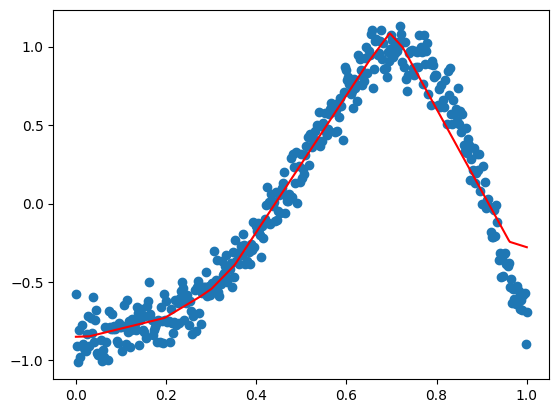

In [28]:
fcekf_post_nr = conditional_moments_gaussian_filter(fcekf_params_nr, EKFIntegrals(), Y_nr_sh, inputs=X_nr_sh)
fcekf_weight_nr = fcekf_post_nr.filtered_means[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(fcekf_weight_nr, X_nr), c='red');

## 3.3 Fully-Decoupled Diagonal EKF

In [29]:
# D-EKF for nonlinear regression
dekf_params_nr = DEKFParams(
    initial_mean=flat_params_nr,
    initial_cov_diag=jnp.ones((state_dim_nr,)),
    dynamics_cov_diag=jnp.ones((state_dim_nr,)) * 0,
    emission_mean_function = lambda w, x: apply_fn_nr(w, x),
    emission_cov_function = lambda w, x: var_nr
)

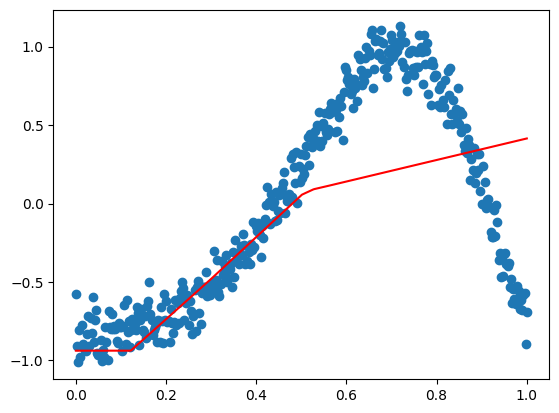

In [30]:
fdekf_post_nr = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_nr, Y_nr_sh, inputs=X_nr_sh)
fdekf_weight_nr = fdekf_post_nr.filtered_means[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(fdekf_weight_nr, X_nr), c='red');

## 3.4 Variational Diagonal EKF

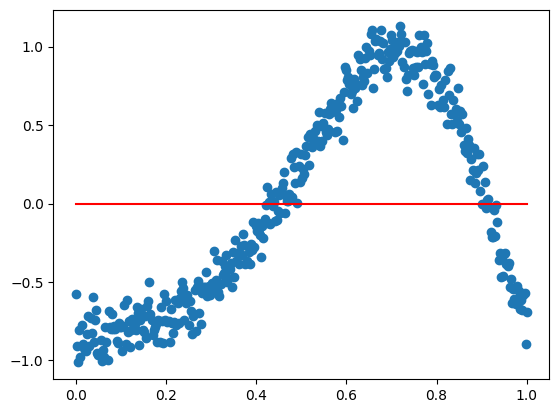

In [31]:
vdekf_post_nr = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_nr, Y_nr_sh, inputs=X_nr_sh)
vdekf_weight_nr = vdekf_post_nr.filtered_means[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(vdekf_weight_nr, X_nr), c='red');

## 3.5 SGD - Single Pass

In [32]:
# L2 loss function for nonlinear regression
loss_fn_nr = partial(loss_optax, loss_fn = optax.l2_loss, apply_fn = apply_fn_nr)

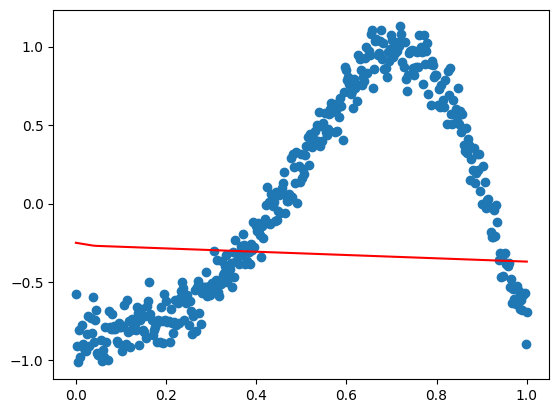

In [33]:
sgd_sp_nr = fit_optax(flat_params_nr, sgd_optimizer, X_nr, Y_nr, loss_fn_nr, num_epochs=1)
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(sgd_sp_nr, X_nr), c='red');

## 3.6 SGD - Multi Pass (200 Epochs)

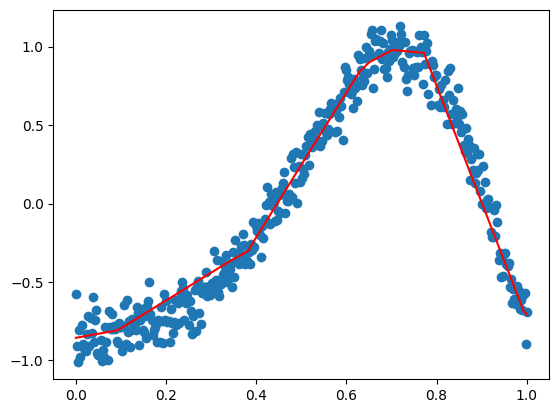

In [34]:
sgd_mp_nr = fit_optax(flat_params_nr, sgd_optimizer, X_nr, Y_nr, loss_fn_nr, num_epochs=200)
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(sgd_mp_nr, X_nr), c='red');

# 4. Demo - Linearly-Separable Classification

## 4.1 Dataset Generation

In [35]:
def generate_input_grid(input):
    """Generate grid on input space.
    Args:
        input (DeviceArray): Input array to determine the range of the grid.
    Returns:
        input_grid: Generated input grid.
    """    
    # Define grid limits
    xmin, ymin = input.min(axis=0) - 0.1
    xmax, ymax = input.max(axis=0) + 0.1

    # Define grid
    step = 0.1
    x_grid, y_grid = jnp.meshgrid(jnp.mgrid[xmin:xmax:step], jnp.mgrid[ymin:ymax:step])
    input_grid = jnp.concatenate([x_grid[...,None], y_grid[...,None]], axis=2)

    return input_grid

In [36]:
def posterior_predictive_grid_ekf(grid, mean, cov, apply, binary=False, ekf_type='fcekf', 
                                  num_samples=100,key=0):
    """Compute posterior predictive probability for each point in grid
    Args:
        grid (DeviceArray): Grid on which to predict posterior probability.
        mean (DeviceArray): Posterior mean of parameters.
        cov (DeviceArray): Posterior cov of parameters.
        apply (Callable): Apply function for MLP.
        binary (bool, optional): Flag to determine whether to round probabilities to binary outputs. Defaults to True.
    Returns:
        _type_: _description_
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    if ekf_type == 'fcekf':
        mvn = MVN(loc=mean, covariance_matrix=cov)
    else:
        mvn = MVND(loc=mean, scale_diag=cov)
    # Sample parameters
    sampled_params = mvn.sample(seed=key, sample_shape=num_samples)
    
    def posterior_predictive_single_param(param):
        inferred_fn = lambda x: apply(param, x)
        fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
        Z = fn_vec(grid)
        if binary:
            Z = jnp.rint(Z)
        return Z
    
    Zs = vmap(posterior_predictive_single_param, (0,))(sampled_params)
    return Zs.mean(axis=0)

In [37]:
def posterior_predictive_grid(grid, mean, apply, binary=False):
    """Compute posterior predictive probability for each point in grid
    Args:
        grid (DeviceArray): Grid on which to predict posterior probability.
        mean (DeviceArray): Posterior mean of parameters.
        apply (Callable): Apply function for MLP.
        binary (bool, optional): Flag to determine whether to round probabilities to binary outputs. Defaults to True.
    Returns:
        _type_: _description_
    """    
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

In [38]:
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    """Plot the 2d posterior predictive distribution.
    Args:
        ax (axis): Matplotlib axis.
        X (DeviceArray): Input array.
        title (str): Title for the plot.
        colors (list): List of colors that correspond to each element in X.
        Xspace (DeviceArray, optional): Input grid to predict on. Defaults to None.
        Zspace (DeviceArray, optional): Predicted posterior on the input grid. Defaults to None.
        cmap (str, optional): Matplotlib colormap. Defaults to "viridis".
    """    
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    plt.tight_layout()
    return ax

In [39]:
def generate_linearly_separable_dataset(num_per_class=250, key=1):
    X, y = datasets.make_blobs(n_samples=500, centers=2, n_features=2, center_box=(0, 10), random_state=key)
    scaler = preprocessing.StandardScaler()
    X = jnp.array(scaler.fit_transform(X))
    y = jnp.array(y.astype('float'))
    return X, y

In [40]:
X_lc, Y_lc = generate_linearly_separable_dataset()

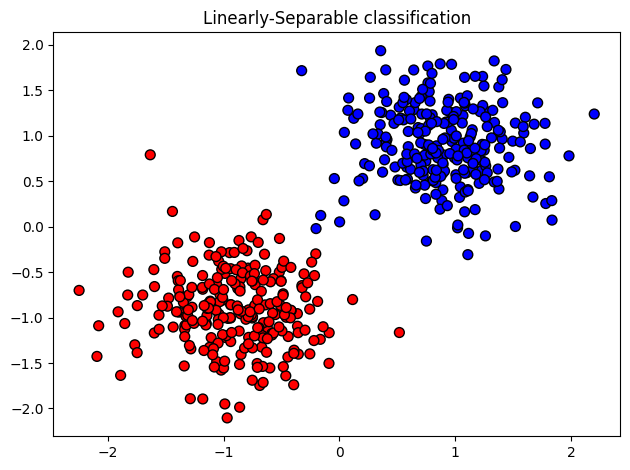

In [41]:
fig, ax = plt.subplots()
plot_posterior_predictive(ax, X_lc, Y_lc, "Linearly-Separable classification");

In [42]:
# MLP for linearly-separable classification
input_dim_lc, hidden_dims_lc, output_dim_lc = 2, [5, 5], 1
model_dims_lc = [input_dim_lc, *hidden_dims_lc, output_dim_lc]
_, flat_params_lc, _, apply_fn_lc = get_mlp_flattened_params(model_dims_lc)
print(flat_params_lc.shape)

(51,)


## 4.2 Full Covariance CMGF-EKF

In [43]:
# CMGF-EKF for MLP Classifier
state_dim_lc, emission_dim_lc = flat_params_lc.size, output_dim_lc
eps_lc = 1e-4
sigmoid_fn_lc = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn_lc(w, x)), eps_lc, 1-eps_lc) # Clip to prevent divergence
fcekf_params_lc = ParamsGGSSM(
    initial_mean=flat_params_lc,
    initial_covariance=jnp.eye(state_dim_lc),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_lc) * 0,
    emission_mean_function = lambda w, x: sigmoid_fn_lc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_lc(w, x) * (1 - sigmoid_fn_lc(w, x))
)

In [44]:
fcekf_post_lc = conditional_moments_gaussian_filter(fcekf_params_lc, EKFIntegrals(), Y_lc, inputs=X_lc)
fcekf_weight_lc = fcekf_post_lc.filtered_means[-1]
fcekf_cov_lc = fcekf_post_lc.filtered_covariances[-1]

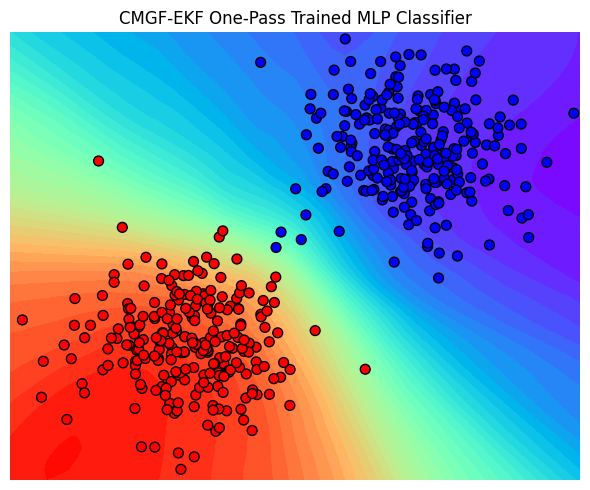

In [45]:
input_grid_lc = generate_input_grid(X_lc)

# Evaluate the trained MLP on grid and plot
Z_fcekf_lc = posterior_predictive_grid_ekf(input_grid_lc, fcekf_weight_lc, fcekf_cov_lc, sigmoid_fn_lc)
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_fcekf_lc);

## 4.3 Fully-Decoupled Diagonal EKF

In [46]:
dekf_params_lc = DEKFParams(
    initial_mean=flat_params_lc,
    initial_cov_diag=jnp.ones((state_dim_lc,)),
    dynamics_cov_diag=jnp.ones((state_dim_lc,)) * 1e-4,
    emission_mean_function = lambda w, x: sigmoid_fn_lc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_lc(w, x) * (1 - sigmoid_fn_lc(w, x))
)

In [47]:
fdekf_post_lc = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_lc, Y_lc, inputs=X_lc)
fdekf_weight_lc = fdekf_post_lc.filtered_means[-1]
fdekf_cov_lc = fdekf_post_lc.filtered_covariances[-1]

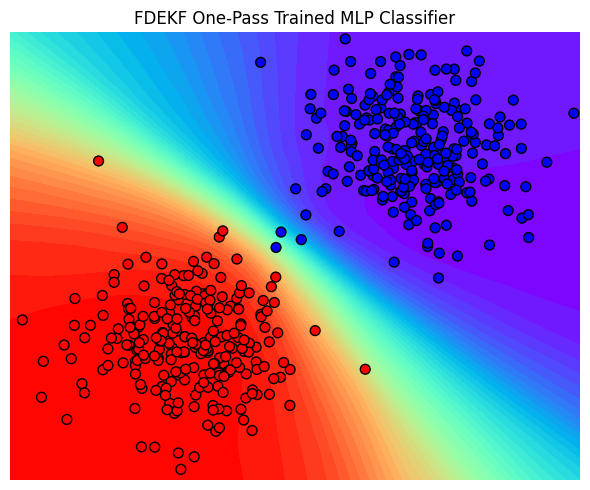

In [48]:
# Evaluate the trained MLP on grid and plot
Z_fdekf_lc = posterior_predictive_grid_ekf(input_grid_lc, fdekf_weight_lc, fdekf_cov_lc, sigmoid_fn_lc, binary=False,
                                       ekf_type='fdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "FDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_fdekf_lc);

## 4.4 Variational Diagonal EKF

In [49]:
vdekf_post_lc = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_lc, Y_lc, inputs=X_lc)
vdekf_weight_lc = vdekf_post_lc.filtered_means[-1]
vdekf_cov_lc = vdekf_post_lc.filtered_covariances[-1]

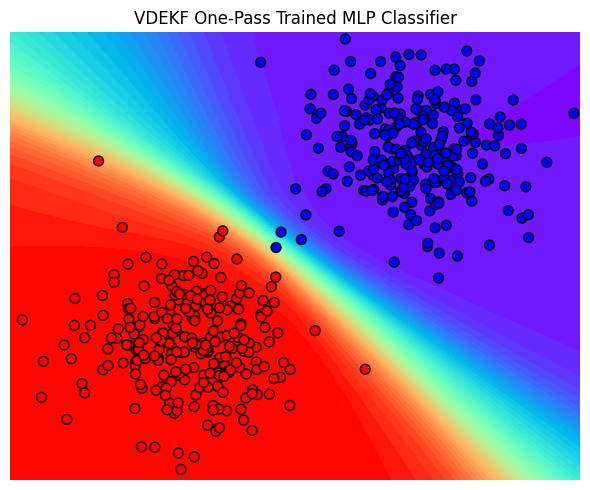

In [50]:
# Evaluate the trained MLP on grid and plot
Z_vdekf_lc = posterior_predictive_grid_ekf(input_grid_lc, vdekf_weight_lc, 
                                       vdekf_cov_lc, sigmoid_fn_lc, binary=False, ekf_type='vdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "VDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_vdekf_lc);

## 4.5 SGD - Single Pass

In [51]:
# Cross entropy loss for linear classification
loss_fn_lc = partial(loss_optax, loss_fn = lambda y, yhat: -(y * jnp.log(yhat) + (1-y) * jnp.log(1 - yhat)), 
                     apply_fn = sigmoid_fn_lc)

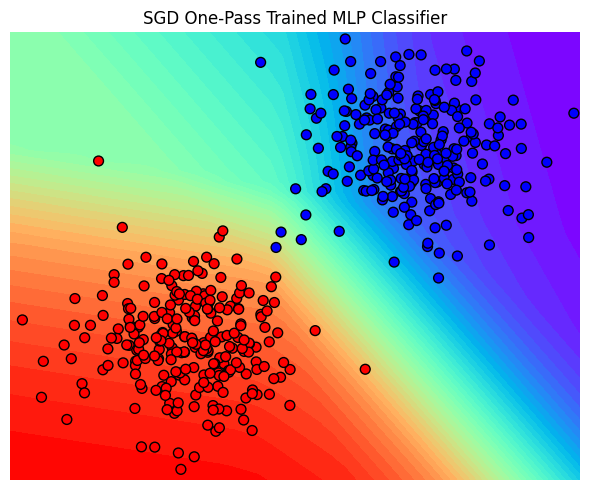

In [52]:
sgd_sp_lc = fit_optax(flat_params_lc, sgd_optimizer, X_lc, Y_lc, loss_fn_lc, num_epochs=1)

# Evaluate the trained MLP on grid and plot
Z_sgd_sp_lc = posterior_predictive_grid(input_grid_lc, sgd_sp_lc, sigmoid_fn_lc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_sgd_sp_lc);

## 4.6 SGD - Multi Pass (200 Epochs)

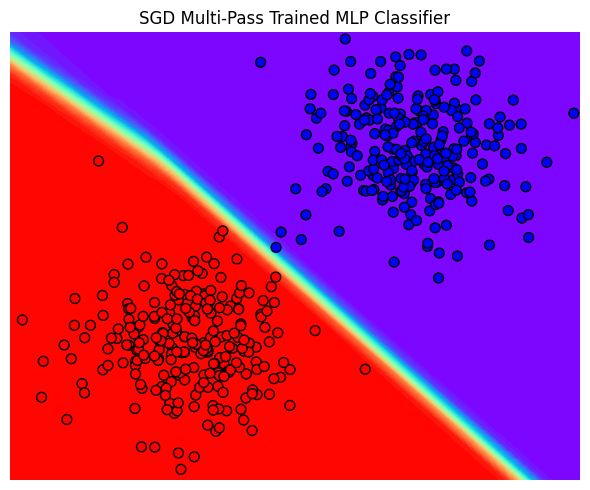

In [53]:
sgd_mp_lc = fit_optax(flat_params_lc, sgd_optimizer, X_lc, Y_lc, loss_fn_lc, num_epochs=200)

# Evaluate the trained MLP on grid and plot
Z_sgd_mp_lc = posterior_predictive_grid(input_grid_lc, sgd_mp_lc, sigmoid_fn_lc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD Multi-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_sgd_mp_lc);

# 5. Demo - Nonlinear Classification

## 5.0 Evaluation

In [54]:
# Define MLP architecture
input_dim_nc, hidden_dims_nc, output_dim_nc = 2, [25, 25], 1
model_dims_nc = [input_dim_nc, *hidden_dims_nc, output_dim_nc]
_, flat_params_nc, _, apply_fn_nc = get_mlp_flattened_params(model_dims_nc)
print(flat_params_nc.shape)

(751,)


In [55]:
eps_nc = 1e-4
sigmoid_fn_nc = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn_nc(w, x)), eps_nc, 1-eps_nc) # Clip to prevent divergence

In [56]:
@partial(jit, static_argnums=(4, 5))
def evaluate_posterior(params, cov, X_test, y_test, 
                       posterior_predictive_estimation='map',
                       cov_type='full', num_samples=100, key=0):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(params, X, y):
        logit = sigmoid_fn_nc(params, X)
        return -y * jnp.log(logit) - (1 - y) * jnp.log(1 - logit)

    @jit
    def evaluate_misclass(params, X, y):
        logit = sigmoid_fn_nc(params, X)
        return jnp.where(abs(logit - y) < 0.5, 0, 1)
    
    @jit
    def evaluate_linearized_nll(params_map, params, X, y):
        apply = lambda p: sigmoid_fn_nc(p, X)
        H = _jacrev_2d(apply, params_map)
        logit = jnp.clip(apply(params_map) + H @ (params - params_map), eps_nc, 1-eps_nc)
        return -y * jnp.log(logit) - (1 - y) * jnp.log(1 - logit)

    @jit
    def evaluate_linearized_misclass(params_map, params, X, y):
        apply = lambda p: sigmoid_fn_nc(p, X)
        H = _jacrev_2d(apply, params_map)
        logit = apply(params_map) + H @ (params - params_map)
        return jnp.where(abs(logit - y) < 0.5, 0, 1)
    
    if posterior_predictive_estimation == 'map':
        nlls = vmap(evaluate_nll, (None, 0, 0))(params, X_test, y_test)
        accs = vmap(evaluate_misclass, (None, 0, 0))(params, X_test, y_test)
        result = {'nll': nlls.mean(), 'accs': accs.mean()}
        return result
    # elif posterior_predictive_estimation == 'wu':

    if isinstance(key, int):
        key = jr.PRNGKey(key)

    if cov_type == 'full':
        mvn = MVN(loc=params, covariance_matrix=cov)
    elif cov_type == 'diagonal':
        mvn = MVND(loc=params, scale_diag=cov)
    else:
        raise ValueError()

    sampled_params = mvn.sample(seed=key, sample_shape=num_samples)

    if posterior_predictive_estimation == 'mc':
        evaluate_average_nll = lambda p: vmap(evaluate_nll, (None, 0, 0))(p, X_test, y_test)
        evaluate_average_acc = lambda p: vmap(evaluate_misclass, (None, 0, 0))(p, X_test, y_test)
    elif posterior_predictive_estimation == 'immer':
        evaluate_average_nll = lambda p: vmap(evaluate_linearized_nll, (None, None, 0, 0))(params, p, X_test, y_test)
        evaluate_average_acc = lambda p: vmap(evaluate_linearized_misclass, (None, None, 0, 0))(params, p, X_test, y_test)
    else:
        raise ValueError()
    nlls = vmap(evaluate_average_nll)(sampled_params)
    accs = vmap(evaluate_average_acc)(sampled_params)
    result = {'nll': nlls.mean(), 'accs': accs.mean()}
    return result

In [71]:
# SGD fit function
def fit_optax(params, optimizer, input, output, loss_fn, num_epochs=200, return_history=False):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, x, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    if return_history:
        params_history=[]

    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(zip(input, output)):
            params, opt_state, loss_value = step(params, opt_state, x, y)
            if return_history:
                params_history.append(params)
    
    if return_history:
        return jnp.array(params_history)
    return params

In [57]:
@jit
def evaluate_sgd(params, X_test, y_test):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(params, X, y):
        logit = sigmoid_fn_nc(params, X)
        return -y * jnp.log(logit) - (1 - y) * jnp.log(1 - logit)

    @jit
    def evaluate_misclass(params, X, y):
        logit = sigmoid_fn_nc(params, X)
        return jnp.where(abs(logit - y) < 0.5, 0, 1)
    
    nlls = vmap(evaluate_nll, (None, 0, 0))(params, X_test, y_test)
    accs = vmap(evaluate_misclass, (None, 0, 0))(params, X_test, y_test)
    result = {'nll': nlls.mean(), 'accs': accs.mean()}
    return result

## 5.1 Dataset Generation

In [58]:
def generate_spiral_dataset(num_per_class=500, validation_split=0.2, test_split=0.3, zero_var=1., one_var=1., shuffle=True, key=0):
    """Generate balanced, standardized 2d "spiral" binary classification dataset.
    Code adapted from https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
    Args:
        num_per_class (int, optional): Number of points to generate per class. Defaults to 250.
        zero_val (float, optional): Noise variance for inputs withj label '0'. Defaults to 1.
        one_val (float, optional): Noise variance for inputs withj label '1'. Defaults to 1.
        shuffle (bool, optional): Flag to determine whether to return shuffled dataset. Defaults to True.
        key (int, optional): Initial PRNG seed for jax.random. Defaults to 0.
    Returns:
        input: Generated input.
        output: Generated binary output.
    """    
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, key3, key4 = jr.split(key, 4)

    theta = jnp.sqrt(jr.uniform(key1, shape=(num_per_class,))) * 2*jnp.pi
    r = 2*theta + jnp.pi
    generate_data = lambda theta, r: jnp.array([jnp.cos(theta)*r, jnp.sin(theta)*r]).T

    # Input data for output zero
    zero_input = generate_data(theta, r) + zero_var * jr.normal(key2, shape=(num_per_class, 2))

    # Input data for output one
    one_input = generate_data(theta, -r) + one_var * jr.normal(key3, shape=(num_per_class, 2))

    # Stack the inputs and standardize
    input = jnp.concatenate([zero_input, one_input])
    input = (input - input.mean(axis=0)) / input.std(axis=0)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros(num_per_class), jnp.ones(num_per_class)])

    if shuffle:
        idx = jr.permutation(key4, jnp.arange(num_per_class * 2))
        input, output = input[idx], output[idx]

    val_index, test_index = num_per_class, int(1.4 * num_per_class)
    X_train, X_val, X_test = input[:val_index], input[val_index:test_index], input[test_index:]
    y_train, y_val, y_test = output[:val_index], output[val_index:test_index], output[test_index:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [59]:
num_per_class=1000
X_train, X_val, X_test, y_train, y_val, y_test = generate_spiral_dataset(num_per_class)

In [60]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1000, 2)
(400, 2)
(600, 2)


In [61]:
# Define MLP architecture
input_dim_nc, hidden_dims_nc, output_dim_nc = 2, [25, 25], 1
model_dims_nc = [input_dim_nc, *hidden_dims_nc, output_dim_nc]
_, flat_params_nc, _, apply_fn_nc = get_mlp_flattened_params(model_dims_nc)
print(flat_params_nc.shape)

(751,)


## 5.2 Model Comparison

In [62]:
def apply_hyperparam(init_var, dynamics_var, model_dim):
    # Generate MLP model with specified dimensions
    _, flat_params_nc, _, apply_fn_nc = get_mlp_flattened_params(model_dims_nc)
    output_dim_nc = model_dim[-1]

    # FCEKF parameters
    state_dim_nc = flat_params_nc.size
    eps_nc = 1e-4
    sigmoid_fn_nc = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn_nc(w, x)), eps_nc, 1-eps_nc) # Clip to prevent divergence
    fcekf_params_nc = ParamsGGSSM(
        initial_mean=flat_params_nc,
        initial_covariance=jnp.eye(state_dim_nc) * init_var,
        dynamics_function=lambda w, _: w,
        dynamics_covariance = jnp.eye(state_dim_nc) * dynamics_var,
        emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
        emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
    )

    # DEKF parameters
    dekf_params_nc = DEKFParams(
        initial_mean=flat_params_nc,
        initial_cov_diag=jnp.ones((state_dim_nc,)) * init_var,
        dynamics_cov_diag=jnp.ones((state_dim_nc,)) * dynamics_var,
        emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
        emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
    )

    # Loss function
    loss_fn_nc = partial(loss_optax, loss_fn = lambda y, yhat: -(y * jnp.log(yhat) + (1-y) * jnp.log(1 - yhat)), 
                         apply_fn = sigmoid_fn_nc)

    return fcekf_params_nc, dekf_params_nc, flat_params_nc, loss_fn_nc

In [80]:
from tqdm import tqdm

def generate_model_comparison_table(init_var_grid, dynamics_var_grid, model_dim_grid,
                                    X_train, y_train, X_test, y_test):
    result = dict()

    # NLLs and accuracies for test set
    evaluate_posterior_map = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'map')
    evaluate_posterior_mc = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'mc')
    evaluate_posterior_immer = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'immer')

    # SGD Optimizer
    sgd_optimizer = optax.sgd(learning_rate=1e-1, momentum=5e-1)

    for model_dim_type, model_dim in model_dim_grid.items():
        result[model_dim_type] = dict()
        for init_var in init_var_grid:
            result[model_dim_type][init_var] = dict()
            for dynamics_var in tqdm(dynamics_var_grid, desc=f'model_dim={model_dim_type}, init_var={init_var}'):
                result[model_dim_type][init_var][dynamics_var] = dict()
                fcekf_params, dekf_params, flat_params, loss_fn = apply_hyperparam(init_var, dynamics_var, model_dim)
                fcekf_post = conditional_moments_gaussian_filter(fcekf_params, EKFIntegrals(), y_train, inputs=X_train)
                fdekf_post = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params, y_train, inputs=X_train)
                vdekf_post = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params, y_train, inputs=X_train)
                posts = {'fcekf': fcekf_post, 'fdekf': fdekf_post, 'vdekf': vdekf_post}
                for post_type, post in posts.items():
                    print(post_type)
                    result[model_dim_type][init_var][dynamics_var][post_type] = dict()
                    result_map = vmap(evaluate_posterior_map, (0, 0))(post.filtered_means, post.filtered_covariances)
                    result_mc = vmap(evaluate_posterior_mc, (0, 0))(post.filtered_means, post.filtered_covariances)
                    result_immer = vmap(evaluate_posterior_immer, (0, 0))(post.filtered_means, post.filtered_covariances)
                    result_nlls = {'map': result_map['nll'], 'mc': result_mc['nll'], 'immer': result_immer['nll']}
                    for est_type, result_nll in result_nlls.items():
                        result[model_dim_type][init_var][dynamics_var][post_type][est_type] = result_nll

                sgd_post = fit_optax(flat_params, sgd_optimizer, X_train, y_train, loss_fn, num_epochs=1, return_history=True)
                sgd_nll = evaluate_sgd(sgd_post, X_test, y_test)['nll']
                result[model_dim_type][init_var][dynamics_var][post_type]['sgd'] = sgd_nll
    return result

In [73]:
input_dim_nc, hidden_dims_nc, output_dim_nc = 2, [25, 25], 1
model_dims_nc = [input_dim_nc, *hidden_dims_nc, output_dim_nc]
model_dims_nc

[2, 25, 25, 1]

In [76]:
init_var, dynamics_var = 1.0, 0.1
fcekf_params, dekf_params, flat_params, loss_fn = apply_hyperparam(init_var, dynamics_var, model_dims_nc)

In [77]:
fcekf_post_nc = conditional_moments_gaussian_filter(fcekf_params, EKFIntegrals(), y_train, inputs=X_train)

In [78]:
evaluate_posterior_map = lambda p, c: evaluate_posterior(p, c, X_test, y_test)
evaluate_posterior_mc = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'mc')
evaluate_posterior_immer = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'immer')

In [79]:
fcekf_result_map = vmap(evaluate_posterior_map, (0, 0))(fcekf_post_nc.filtered_means, fcekf_post_nc.filtered_covariances)
fcekf_result_mc = vmap(evaluate_posterior_mc, (0, 0))(fcekf_post_nc.filtered_means, fcekf_post_nc.filtered_covariances)
fcekf_result_immer = vmap(evaluate_posterior_immer, (0, 0))(fcekf_post_nc.filtered_means, fcekf_post_nc.filtered_covariances)

2022-12-09 12:10:15.345316: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2153] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Attempting to reserve 9.55G at the bottom of memory. That was not possible. There are 10.99G free, 0B reserved, and 6.59G reservable. If fragmentation is eliminated, the maximum reservable bytes would be 10.99G, so compaction will enable this reservation.  The nearest obstacle is at 6.59G from the bottom with size 2.94M.


XlaRuntimeError: RESOURCE_EXHAUSTED: Attempting to reserve 9.55G at the bottom of memory. That was not possible. There are 10.99G free, 0B reserved, and 6.59G reservable. If fragmentation is eliminated, the maximum reservable bytes would be 10.99G, so compaction will enable this reservation.  The nearest obstacle is at 6.59G from the bottom with size 2.94M.

In [72]:
import traceback

init_var_grid = [1.0]
dynamics_var_grid = [0.1]
model_dim_grid = {'MLP1': [2, 25, 25, 1]}

generate_model_comparison_table(init_var_grid, dynamics_var_grid, model_dim_grid, X_train, y_train, X_test, y_test)

model_dim=MLP1, init_var=1.0:   0%|          | 0/1 [00:04<?, ?it/s]


TypeError: reshape total size must be unchanged, got new_sizes (25,) for shape (25, 751).

## 5.2 Full Covariance CMGF-EKF

## 5.2.1 Initial Covariance Grid Search

In [82]:
# FCEKF for nonlinear classification
state_dim_nc, emission_dim_nc = flat_params_nc.size, output_dim_nc
eps_nc = 1e-4
sigmoid_fn_nc = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn_nc(w, x)), eps_nc, 1-eps_nc) # Clip to prevent divergence
fcekf_params_nc = ParamsGGSSM(
    initial_mean=flat_params_nc,
    initial_covariance=jnp.eye(state_dim_nc),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_nc) * 0,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)
input_grid_nc = generate_input_grid(X_train)

In [390]:
# Grid search for hyperparams
init_vars = jnp.array([jnp.arange(9, 0, -1) * dec for dec in [1, 1e-1, 1e-2, 1e-3]]).ravel()
fcekf_gridsearch_result = {'init_var_map': 0.0, 'final_nll_map': 10.0, 'init_var_mc': 0.0, 
                           'final_nll_mc': 10.0, 'initial_var_immer': 0.0, 'final_nll_immer': 10.0}
for init_var in init_vars:
    print(f'Trying init_var = {init_var}...')
    fcekf_params_nc = ParamsGGSSM(
        initial_mean=flat_params_nc,
        initial_covariance=jnp.eye(state_dim_nc) * init_var,
        dynamics_function=lambda w, _: w,
        dynamics_covariance = jnp.eye(state_dim_nc) * 0,
        emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
        emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
    )
    fcekf_post_nc = conditional_moments_gaussian_filter(fcekf_params_nc, EKFIntegrals(), y_train, inputs=X_train)
    # nlls = vmap(evaluate_accuracy, (0, None, None))(fcekf_post_nc.filtered_means, X_val, y_val)
    final_nll_map = evaluate_posterior(fcekf_post_nc.filtered_means[-1], fcekf_post_nc.filtered_covariances[-1], X_val, y_val, 'map')['nll']
    final_nll_mc = evaluate_posterior(fcekf_post_nc.filtered_means[-1], fcekf_post_nc.filtered_covariances[-1], X_val, y_val, 'mc')['nll']
    final_nll_immer = evaluate_posterior(fcekf_post_nc.filtered_means[-1], fcekf_post_nc.filtered_covariances[-1], X_val, y_val, 'mc')['nll']
    print(f'final_nll_map={final_nll_map}\nfinal_nll_mc={final_nll_mc}\nfinal_nll_immer={final_nll_immer}\n')
    if final_nll_map < fcekf_gridsearch_result['final_nll_map']:
        fcekf_gridsearch_result['init_var_map'] = init_var
        fcekf_gridsearch_result['final_nll_map'] = final_nll_map
    if final_nll_mc < fcekf_gridsearch_result['final_nll_mc']:
        fcekf_gridsearch_result['init_var_mc'] = init_var
        fcekf_gridsearch_result['final_nll_mc'] = final_nll_mc
    if final_nll_immer < fcekf_gridsearch_result['final_nll_immer']:
        fcekf_gridsearch_result['init_var_immer'] = init_var
        fcekf_gridsearch_result['final_nll_immer'] = final_nll_immer


Trying init_var = 9.0...
final_nll_map=4.4612298011779785
final_nll_mc=4.512070655822754
final_nll_immer=4.512070655822754

Trying init_var = 8.0...
final_nll_map=4.4612298011779785
final_nll_mc=4.409322261810303
final_nll_immer=4.409322261810303

Trying init_var = 7.0...
final_nll_map=4.7491302490234375
final_nll_mc=4.716394901275635
final_nll_immer=4.716394901275635

Trying init_var = 6.0...
final_nll_map=4.749131202697754
final_nll_mc=4.647699356079102
final_nll_immer=4.647699356079102

Trying init_var = 5.0...
final_nll_map=4.7491302490234375
final_nll_mc=4.6298041343688965
final_nll_immer=4.6298041343688965

Trying init_var = 4.0...
final_nll_map=4.7491302490234375
final_nll_mc=4.254995346069336
final_nll_immer=4.254995346069336

Trying init_var = 3.0...
final_nll_map=0.020663514733314514
final_nll_mc=4.253070831298828
final_nll_immer=4.253070831298828

Trying init_var = 2.0...
final_nll_map=0.040482450276613235
final_nll_mc=3.6553127765655518
final_nll_immer=3.6553127765655518

T

In [392]:
# Grid search result: init_var=3.0
print(f'Grid search for FCEKF-MAP result: init_var={fcekf_gridsearch_result["init_var_map"]:.3f}')
# Grid search result: init_var=9e-2
print(f'Grid search for FCEKF-MC result: init_var={fcekf_gridsearch_result["init_var_mc"]:.3f}')
# Grid search result: init_var=9e-2
print(f'Grid search for FCEKF-Immer result: init_var={fcekf_gridsearch_result["init_var_immer"]:.3f}')

Grid search for FCEKF-MAP result: init_var=3.000
Grid search for FCEKF-MC result: init_var=0.090
Grid search for FCEKF-Immer result: init_var=0.090


## 5.2.2 Test Set Evaluation

In [83]:
# Train again
fcekf_params_nc_map = ParamsGGSSM(
    initial_mean=flat_params_nc,
    initial_covariance=jnp.eye(state_dim_nc) * 3.0,
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_nc) * 0,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)
fcekf_params_nc_mc = ParamsGGSSM(
    initial_mean=flat_params_nc,
    initial_covariance=jnp.eye(state_dim_nc) * 9e-2,
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_nc) * 0,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)
fcekf_params_nc_immer = fcekf_params_nc_mc

fcekf_post_nc_map = conditional_moments_gaussian_filter(fcekf_params_nc_map, EKFIntegrals(), y_train, inputs=X_train)
fcekf_post_nc_mc = conditional_moments_gaussian_filter(fcekf_params_nc_mc, EKFIntegrals(), y_train, inputs=X_train)
fcekf_post_nc_immer = conditional_moments_gaussian_filter(fcekf_params_nc_immer, EKFIntegrals(), y_train, inputs=X_train)

In [394]:
# NLLs and accuracies for test set
evaluate_posterior_map = lambda p, c: evaluate_posterior(p, c, X_test, y_test)
evaluate_posterior_mc = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'mc')
evaluate_posterior_immer = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'immer')

fcekf_result_map = vmap(evaluate_posterior_map, (0, 0))(fcekf_post_nc_map.filtered_means, fcekf_post_nc_map.filtered_covariances)
fcekf_result_mc = vmap(evaluate_posterior_mc, (0, 0))(fcekf_post_nc_mc.filtered_means, fcekf_post_nc_mc.filtered_covariances)
fcekf_result_immer = vmap(evaluate_posterior_immer, (0, 0))(fcekf_post_nc_immer.filtered_means, fcekf_post_nc_immer.filtered_covariances)

NLLs

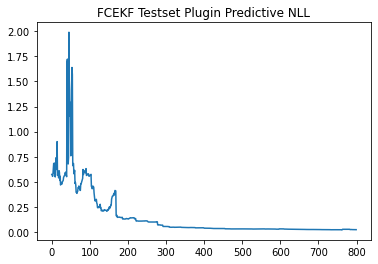

In [395]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fcekf_result_map['nll'])
ax.set_title('FCEKF Testset Plugin Predictive NLL');

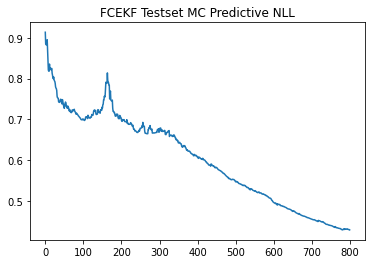

In [396]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fcekf_result_mc['nll'])
ax.set_title('FCEKF Testset MC Predictive NLL');

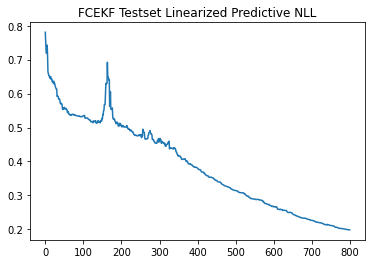

In [397]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fcekf_result_immer['nll'])
ax.set_title('FCEKF Testset Linearized Predictive NLL');

Misclassification Rates

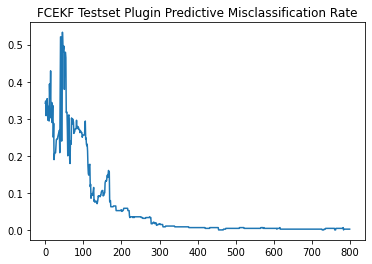

In [398]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fcekf_result_map['accs'])
ax.set_title('FCEKF Testset Plugin Predictive Misclassification Rate');

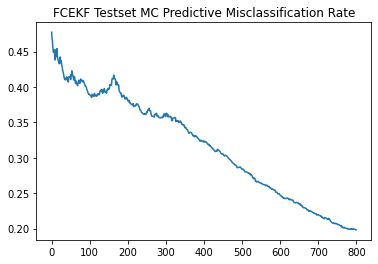

In [399]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fcekf_result_mc['accs'])
ax.set_title('FCEKF Testset MC Predictive Misclassification Rate');

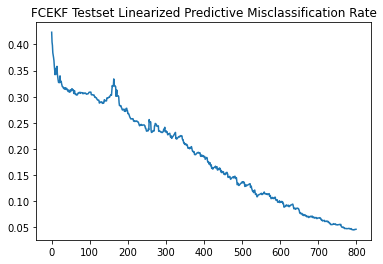

In [402]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fcekf_result_immer['accs'])
ax.set_title('FCEKF Testset Linearized Predictive Misclassification Rate');

## 5.2.3 Training Process Visualization

In [403]:
fcekf_weights_nc = fcekf_post_nc_map.filtered_means
fcekf_covs_nc = fcekf_post_nc_map.filtered_covariances
fcekf_weight_nc = fcekf_weights_nc[-1]
fcekf_cov_nc = fcekf_covs_nc[-1]

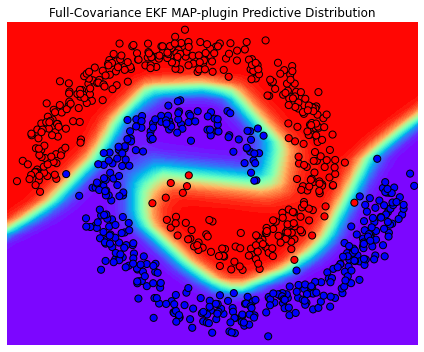

In [404]:
input_grid_nc = generate_input_grid(X_train)

# Evaluate the trained MLP on grid using MAP "plugin"
Z_fcekf_nc = posterior_predictive_grid(input_grid_nc, fcekf_weight_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "Full-Covariance EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(ax, X_train, y_train, title, input_grid_nc, Z_fcekf_nc);
fig.savefig('hm_fcekf_map.jpg', bbox_inches = 'tight')

In [405]:
fcekf_weights_nc = fcekf_post_nc_mc.filtered_means
fcekf_covs_nc = fcekf_post_nc_mc.filtered_covariances
fcekf_weight_nc = fcekf_weights_nc[-1]
fcekf_cov_nc = fcekf_covs_nc[-1]

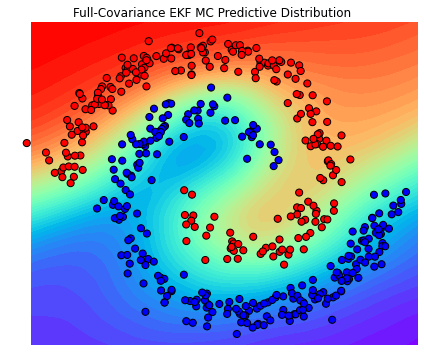

In [406]:
# Laplace-approximation of posterior predictive
Z_fcekf_nc_laplace = posterior_predictive_grid_ekf(input_grid_nc, fcekf_weight_nc,
                                                   fcekf_cov_nc, sigmoid_fn_nc, binary=False,
                                                   ekf_type='fcekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "Full-Covariance EKF MC Predictive Distribution"
plot_posterior_predictive(ax, X_test, y_test, title, input_grid_nc, Z_fcekf_nc_laplace);
fig.savefig('hm_fcekf_mc.jpg', bbox_inches = 'tight')

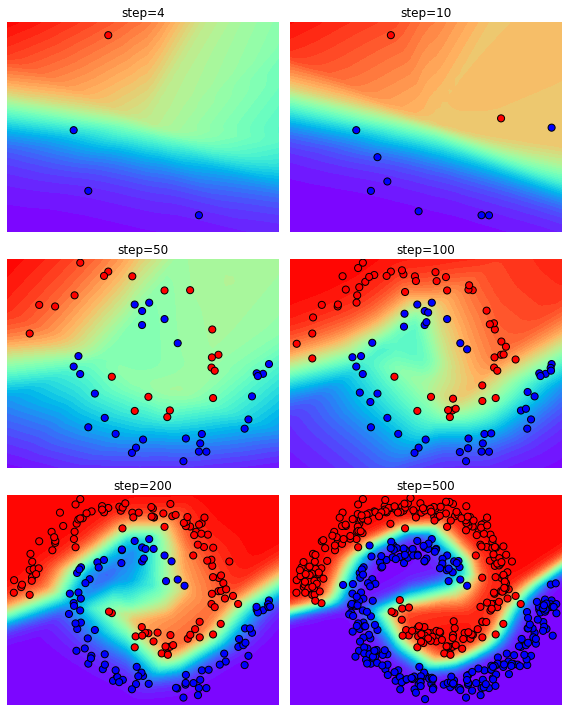

In [77]:
intermediate_steps = [3, 9, 49, 99, 199, num_per_class*2-1]
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid_nc, fcekf_weights_nc[step], sigmoid_fn_nc, binary=False)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, X_nc[:step+1], Y_nc[:step+1], title, input_grid_nc, Zi)
plt.tight_layout()

## 5.3 Fully-Decoupled Diagonal EKF

## 5.3.1 Initial Covariance Grid Search

In [407]:
# Grid search for hyperparams
init_vars = jnp.array([jnp.arange(9, 0, -1) * dec for dec in [1, 1e-1, 1e-2, 1e-3]]).ravel()
fdekf_gridsearch_result = {'init_var_map': 0.0, 'final_nll_map': 10.0, 'init_var_mc': 0.0, 
                           'final_nll_mc': 10.0, 'initial_var_immer': 0.0, 'final_nll_immer': 10.0}
for init_var in init_vars:
    print(f'Trying init_var = {init_var}...')
    dekf_params_nc = DEKFParams(
        initial_mean=flat_params_nc,
        initial_cov_diag=jnp.ones((state_dim_nc,)) * init_var,
        dynamics_cov_diag=jnp.ones((state_dim_nc,)) * 0.,
        emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
        emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
    )
    dekf_post_nc = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_nc, y_train, inputs=X_train)
    # nlls = vmap(evaluate_accuracy, (0, None, None))(fcekf_post_nc.filtered_means, X_val, y_val)
    final_nll_map = evaluate_posterior(dekf_post_nc.filtered_means[-1], dekf_post_nc.filtered_covariances[-1], X_val, y_val, 'map', cov_type='diagonal')['nll']
    final_nll_mc = evaluate_posterior(dekf_post_nc.filtered_means[-1], dekf_post_nc.filtered_covariances[-1], X_val, y_val, 'mc', cov_type='diagonal')['nll']
    final_nll_immer = evaluate_posterior(dekf_post_nc.filtered_means[-1], dekf_post_nc.filtered_covariances[-1], X_val, y_val, 'mc', cov_type='diagonal')['nll']
    print(f'final_nll_map={final_nll_map}\nfinal_nll_mc={final_nll_mc}\nfinal_nll_immer={final_nll_immer}\n')
    if final_nll_map < fdekf_gridsearch_result['final_nll_map']:
        fdekf_gridsearch_result['init_var_map'] = init_var
        fdekf_gridsearch_result['final_nll_map'] = final_nll_map
    if final_nll_mc < fdekf_gridsearch_result['final_nll_mc']:
        fdekf_gridsearch_result['init_var_mc'] = init_var
        fdekf_gridsearch_result['final_nll_mc'] = final_nll_mc
    if final_nll_immer < fdekf_gridsearch_result['final_nll_immer']:
        fdekf_gridsearch_result['init_var_immer'] = init_var
        fdekf_gridsearch_result['final_nll_immer'] = final_nll_immer


Trying init_var = 9.0...
final_nll_map=4.4612298011779785
final_nll_mc=4.505119800567627
final_nll_immer=4.505119800567627

Trying init_var = 8.0...
final_nll_map=0.3422679603099823
final_nll_mc=4.619186878204346
final_nll_immer=4.619186878204346

Trying init_var = 7.0...
final_nll_map=0.6927374005317688
final_nll_mc=4.688455581665039
final_nll_immer=4.688455581665039

Trying init_var = 6.0...
final_nll_map=0.6927071213722229
final_nll_mc=4.607316493988037
final_nll_immer=4.607316493988037

Trying init_var = 5.0...
final_nll_map=0.3681487739086151
final_nll_mc=4.593984603881836
final_nll_immer=4.593984603881836

Trying init_var = 4.0...
final_nll_map=0.40892574191093445
final_nll_mc=4.5509161949157715
final_nll_immer=4.5509161949157715

Trying init_var = 3.0...
final_nll_map=0.36296385526657104
final_nll_mc=4.624513626098633
final_nll_immer=4.624513626098633

Trying init_var = 2.0...
final_nll_map=0.06840094923973083
final_nll_mc=4.19655179977417
final_nll_immer=4.19655179977417

Tryin

In [409]:
# Grid search result: init_var=2.0
print(f'Grid search for FDEKF-MAP result: init_var={fdekf_gridsearch_result["init_var_map"]:.3f}')
# Grid search result: init_var=2e-1
print(f'Grid search for FDEKF-MC result: init_var={fdekf_gridsearch_result["init_var_mc"]:.3f}')
# Grid search result: init_var=2e-1
print(f'Grid search for FDEKF-Immer result: init_var={fdekf_gridsearch_result["init_var_immer"]:.3f}')

Grid search for FDEKF-MAP result: init_var=2.000
Grid search for FDEKF-MC result: init_var=0.200
Grid search for FDEKF-Immer result: init_var=0.200


## 5.3.2 Test Set Evaluation

In [410]:
# Train again
fdekf_params_nc_map = DEKFParams(
    initial_mean=flat_params_nc,
    initial_cov_diag=jnp.ones((state_dim_nc,)) * 2.0,
    dynamics_cov_diag=jnp.ones((state_dim_nc,)) * 0.,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)
fdekf_params_nc_mc = DEKFParams(
    initial_mean=flat_params_nc,
    initial_cov_diag=jnp.ones((state_dim_nc,)) * 2e-1,
    dynamics_cov_diag=jnp.ones((state_dim_nc,)) * 0.,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)
fdekf_params_nc_immer = fdekf_params_nc_mc

fdekf_post_nc_map = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(fdekf_params_nc_map, y_train, inputs=X_train)
fdekf_post_nc_mc = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(fdekf_params_nc_mc, y_train, inputs=X_train)
fdekf_post_nc_immer = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(fdekf_params_nc_immer, y_train, inputs=X_train)

In [411]:
# NLLs and accuracies for test set
evaluate_posterior_map = lambda p, c: evaluate_posterior(p, c, X_test, y_test, cov_type='diagonal')
evaluate_posterior_mc = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'mc', cov_type='diagonal')
evaluate_posterior_immer = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'immer', cov_type='diagonal')

fdekf_result_map = vmap(evaluate_posterior_map, (0, 0))(fdekf_post_nc_map.filtered_means, fdekf_post_nc_map.filtered_covariances)
fdekf_result_mc = vmap(evaluate_posterior_mc, (0, 0))(fdekf_post_nc_mc.filtered_means, fdekf_post_nc_mc.filtered_covariances)
fdekf_result_immer = vmap(evaluate_posterior_immer, (0, 0))(fdekf_post_nc_immer.filtered_means, fdekf_post_nc_immer.filtered_covariances)

NLLs

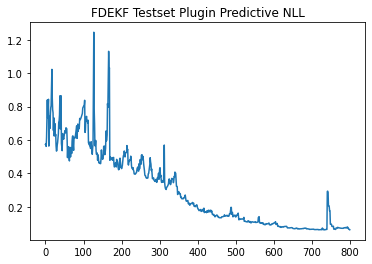

In [412]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fdekf_result_map['nll'])
ax.set_title('FDEKF Testset Plugin Predictive NLL');

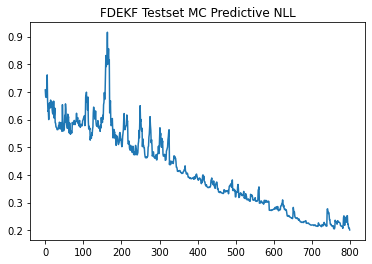

In [413]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fdekf_result_mc['nll'])
ax.set_title('FDEKF Testset MC Predictive NLL');

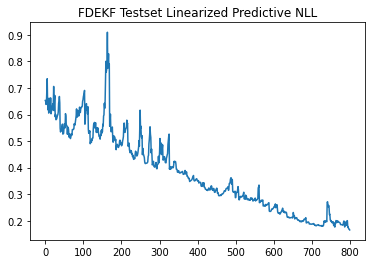

In [414]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fdekf_result_immer['nll'])
ax.set_title('FDEKF Testset Linearized Predictive NLL');

Misclassification Rates

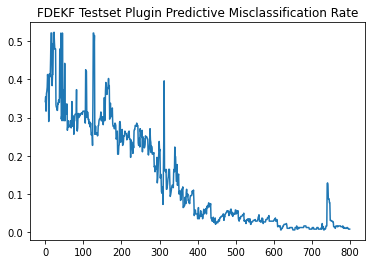

In [415]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fdekf_result_map['accs'])
ax.set_title('FDEKF Testset Plugin Predictive Misclassification Rate');

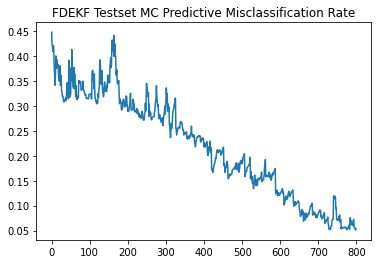

In [416]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fdekf_result_mc['accs'])
ax.set_title('FDEKF Testset MC Predictive Misclassification Rate');

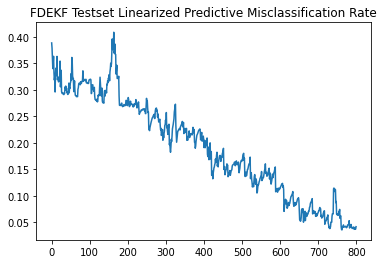

In [417]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, fdekf_result_immer['accs'])
ax.set_title('FDEKF Testset Linearized Predictive Misclassification Rate');

## 5.3.3 Training Process Visualization

In [418]:
fdekf_weights_nc = fdekf_post_nc_map.filtered_means
fdekf_covs_nc = fdekf_post_nc_map.filtered_covariances
fdekf_weight_nc = fdekf_weights_nc[-1]
fdekf_cov_nc = fdekf_covs_nc[-1]

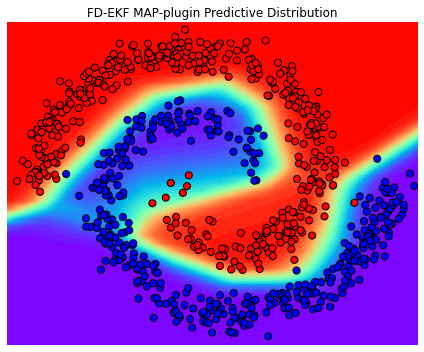

In [419]:
# Evaluate the trained MLP on grid and plot
Z_fdekf_nc = posterior_predictive_grid(input_grid_nc, fdekf_weight_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "FD-EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(ax, X_train, y_train, title, input_grid_nc, Z_fdekf_nc);
fig.savefig('hm_fdekf_map.jpg', bbox_inches = 'tight')

In [420]:
fdekf_weights_nc = fdekf_post_nc_mc.filtered_means
fdekf_covs_nc = fdekf_post_nc_mc.filtered_covariances
fdekf_weight_nc = fdekf_weights_nc[-1]
fdekf_cov_nc = fdekf_covs_nc[-1]

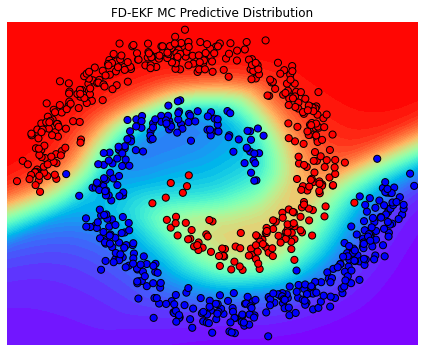

In [421]:
# Evaluate the trained MLP on grid and plot
Z_fdekf_nc_laplace = posterior_predictive_grid_ekf(input_grid_nc, fdekf_weight_nc, 
                                                   fdekf_cov_nc, sigmoid_fn_nc, binary=False,
                                                   ekf_type='fdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "FD-EKF MC Predictive Distribution"
plot_posterior_predictive(ax, X_train, y_train, title, input_grid_nc, Z_fdekf_nc_laplace);
fig.savefig('hm_fdekf_mc.jpg', bbox_inches = 'tight')

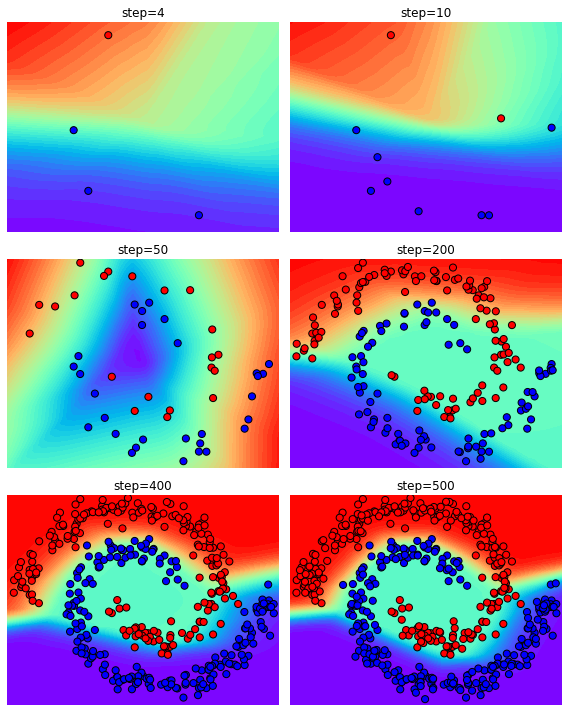

In [83]:
intermediate_steps = [3, 9, 49, 199, 399, num_per_class*2-1]
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid_nc, fdekf_weights_nc[step], sigmoid_fn_nc, binary=False)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, X_nc[:step+1], Y_nc[:step+1], title, input_grid_nc, Zi)
plt.tight_layout()

## 5.4 Variational Diagonal EKF

## 5.4.1 Initial Covariance Grid Search

In [422]:
# Grid search for hyperparams
init_vars = jnp.array([jnp.arange(9, 0, -1) * dec for dec in [1, 1e-1, 1e-2, 1e-3]]).ravel()
vdekf_gridsearch_result = {'init_var_map': 0.0, 'final_nll_map': 10.0, 'init_var_mc': 0.0, 
                           'final_nll_mc': 10.0, 'initial_var_immer': 0.0, 'final_nll_immer': 10.0}
for init_var in init_vars:
    print(f'Trying init_var = {init_var}...')
    dekf_params_nc = DEKFParams(
        initial_mean=flat_params_nc,
        initial_cov_diag=jnp.ones((state_dim_nc,)) * init_var,
        dynamics_cov_diag=jnp.ones((state_dim_nc,)) * 0.,
        emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
        emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
    )
    dekf_post_nc = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_nc, y_train, inputs=X_train)
    # nlls = vmap(evaluate_accuracy, (0, None, None))(fcekf_post_nc.filtered_means, X_val, y_val)
    final_nll_map = evaluate_posterior(dekf_post_nc.filtered_means[-1], dekf_post_nc.filtered_covariances[-1], X_val, y_val, 'map', cov_type='diagonal')['nll']
    final_nll_mc = evaluate_posterior(dekf_post_nc.filtered_means[-1], dekf_post_nc.filtered_covariances[-1], X_val, y_val, 'mc', cov_type='diagonal')['nll']
    final_nll_immer = evaluate_posterior(dekf_post_nc.filtered_means[-1], dekf_post_nc.filtered_covariances[-1], X_val, y_val, 'mc', cov_type='diagonal')['nll']
    print(f'final_nll_map={final_nll_map}\nfinal_nll_mc={final_nll_mc}\nfinal_nll_immer={final_nll_immer}\n')
    if final_nll_map < vdekf_gridsearch_result['final_nll_map']:
        vdekf_gridsearch_result['init_var_map'] = init_var
        vdekf_gridsearch_result['final_nll_map'] = final_nll_map
    if final_nll_mc < vdekf_gridsearch_result['final_nll_mc']:
        vdekf_gridsearch_result['init_var_mc'] = init_var
        vdekf_gridsearch_result['final_nll_mc'] = final_nll_mc
    if final_nll_immer < vdekf_gridsearch_result['final_nll_immer']:
        vdekf_gridsearch_result['init_var_immer'] = init_var
        vdekf_gridsearch_result['final_nll_immer'] = final_nll_immer


Trying init_var = 9.0...
final_nll_map=4.4612298011779785
final_nll_mc=4.63051176071167
final_nll_immer=4.63051176071167

Trying init_var = 8.0...
final_nll_map=4.4612298011779785
final_nll_mc=4.640023708343506
final_nll_immer=4.640023708343506

Trying init_var = 7.0...
final_nll_map=4.7491302490234375
final_nll_mc=4.6676154136657715
final_nll_immer=4.6676154136657715

Trying init_var = 6.0...
final_nll_map=4.7491302490234375
final_nll_mc=4.676928997039795
final_nll_immer=4.676928997039795

Trying init_var = 5.0...
final_nll_map=4.7491302490234375
final_nll_mc=4.748931884765625
final_nll_immer=4.748931884765625

Trying init_var = 4.0...
final_nll_map=4.7491302490234375
final_nll_mc=4.689335823059082
final_nll_immer=4.689335823059082

Trying init_var = 3.0...
final_nll_map=4.7491302490234375
final_nll_mc=5.289262771606445
final_nll_immer=5.289262771606445

Trying init_var = 2.0...
final_nll_map=4.4612298011779785
final_nll_mc=4.480977535247803
final_nll_immer=4.480977535247803

Trying i

In [423]:
# Grid search result: init_var=4e-1
print(f'Grid search for VDEKF-MAP result: init_var={vdekf_gridsearch_result["init_var_map"]:.3f}')
# Grid search result: init_var=3e-1
print(f'Grid search for VDEKF-MC result: init_var={vdekf_gridsearch_result["init_var_mc"]:.3f}')
# Grid search result: init_var=3e-1
print(f'Grid search for VDEKF-Immer result: init_var={vdekf_gridsearch_result["init_var_immer"]:.3f}')

Grid search for VDEKF-MAP result: init_var=0.400
Grid search for VDEKF-MC result: init_var=0.300
Grid search for VDEKF-Immer result: init_var=0.300


## 5.4.2 Test Set Evaluation

In [95]:
# Train again
vdekf_params_nc_map = DEKFParams(
    initial_mean=flat_params_nc,
    initial_cov_diag=jnp.ones((state_dim_nc,)) * 4e-1,
    dynamics_cov_diag=jnp.ones((state_dim_nc,)) * 0.,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)
vdekf_params_nc_mc = DEKFParams(
    initial_mean=flat_params_nc,
    initial_cov_diag=jnp.ones((state_dim_nc,)) * 3e-1,
    dynamics_cov_diag=jnp.ones((state_dim_nc,)) * 0.,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)
vdekf_params_nc_immer = vdekf_params_nc_mc

vdekf_post_nc_map = stationary_dynamics_variational_diagonal_extended_kalman_filter(vdekf_params_nc_map, y_train, inputs=X_train)
vdekf_post_nc_mc = stationary_dynamics_variational_diagonal_extended_kalman_filter(vdekf_params_nc_mc, y_train, inputs=X_train)
vdekf_post_nc_immer = stationary_dynamics_variational_diagonal_extended_kalman_filter(vdekf_params_nc_immer, y_train, inputs=X_train)

In [96]:
# NLLs and accuracies for test set
evaluate_posterior_map = lambda p, c: evaluate_posterior(p, c, X_test, y_test, cov_type='diagonal')
evaluate_posterior_mc = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'mc', cov_type='diagonal')
evaluate_posterior_immer = lambda p, c: evaluate_posterior(p, c, X_test, y_test, 'immer', cov_type='diagonal')

vdekf_result_map = vmap(evaluate_posterior_map, (0, 0))(vdekf_post_nc_map.filtered_means, vdekf_post_nc_map.filtered_covariances)
vdekf_result_mc = vmap(evaluate_posterior_mc, (0, 0))(vdekf_post_nc_mc.filtered_means, vdekf_post_nc_mc.filtered_covariances)
vdekf_result_immer = vmap(evaluate_posterior_immer, (0, 0))(vdekf_post_nc_immer.filtered_means, vdekf_post_nc_immer.filtered_covariances)

NLLs

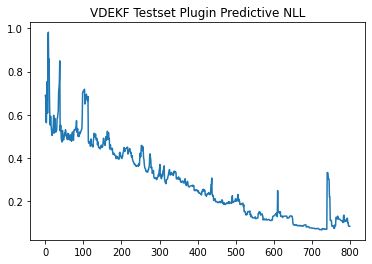

In [426]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, vdekf_result_map['nll'])
ax.set_title('VDEKF Testset Plugin Predictive NLL');

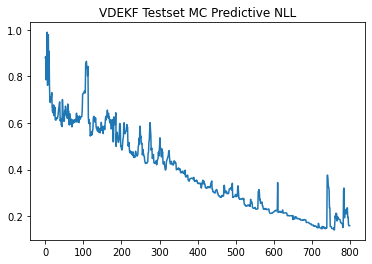

In [427]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, vdekf_result_mc['nll'])
ax.set_title('VDEKF Testset MC Predictive NLL');

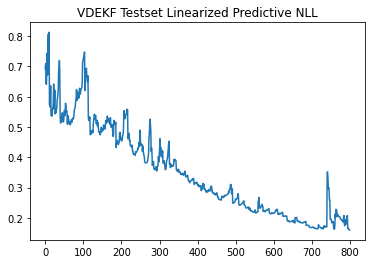

In [428]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, vdekf_result_immer['nll'])
ax.set_title('VDEKF Testset Linearized Predictive NLL');

Misclassification Rates

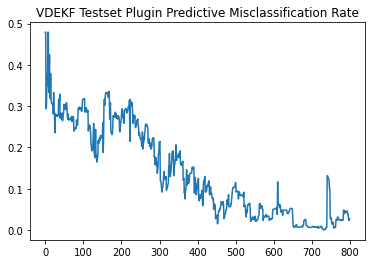

In [429]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, vdekf_result_map['accs'])
ax.set_title('VDEKF Testset Plugin Predictive Misclassification Rate');

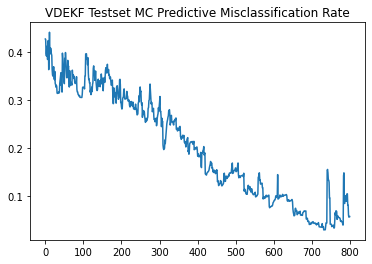

In [430]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, vdekf_result_mc['accs'])
ax.set_title('VDEKF Testset MC Predictive Misclassification Rate');

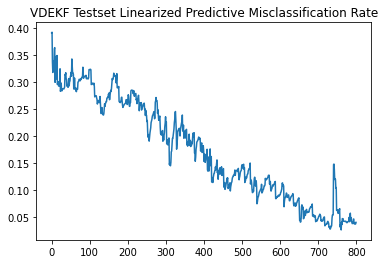

In [431]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, vdekf_result_immer['accs'])
ax.set_title('VDEKF Testset Linearized Predictive Misclassification Rate');

## 5.4.3 Training Process Visualization

In [432]:
vdekf_weights_nc = vdekf_post_nc_map.filtered_means
vdekf_covs_nc = vdekf_post_nc_map.filtered_covariances
vdekf_weight_nc = vdekf_weights_nc[-1]
vdekf_cov_nc = vdekf_covs_nc[-1]

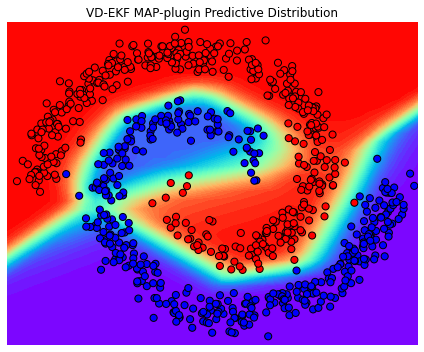

In [433]:
# Evaluate the trained MLP on grid and plot
Z_vdekf_nc = posterior_predictive_grid(input_grid_nc, vdekf_weight_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "VD-EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(ax, X_train, y_train, title, input_grid_nc, Z_vdekf_nc);
fig.savefig('hm_vdekf_map.jpg', bbox_inches = 'tight')

In [434]:
vdekf_weights_nc = vdekf_post_nc_mc.filtered_means
vdekf_covs_nc = vdekf_post_nc_mc.filtered_covariances
vdekf_weight_nc = vdekf_weights_nc[-1]
vdekf_cov_nc = vdekf_covs_nc[-1]

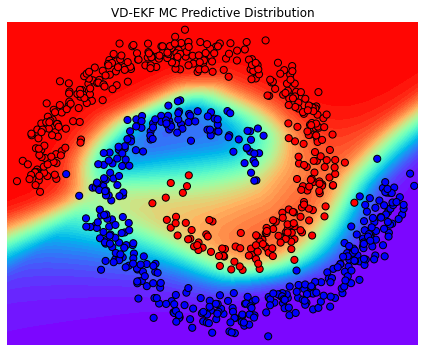

In [435]:
# Evaluate the trained MLP on grid and plot
Z_vdekf_nc_laplace = posterior_predictive_grid_ekf(input_grid_nc, vdekf_weight_nc, vdekf_cov_nc,
                                                   sigmoid_fn_nc, binary=False, ekf_type='vdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "VD-EKF MC Predictive Distribution"
plot_posterior_predictive(ax, X_train, y_train, title, input_grid_nc, Z_vdekf_nc_laplace);
fig.savefig('hm_vdekf_mc.jpg', bbox_inches = 'tight')

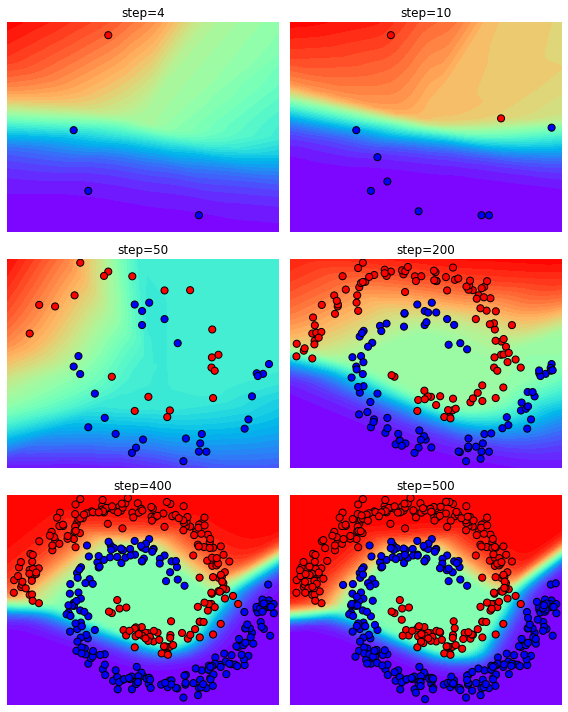

In [88]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid_nc, vdekf_weights_nc[step], sigmoid_fn_nc, binary=False)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, X_nc[:step+1], Y_nc[:step+1], title, input_grid_nc, Zi)
plt.tight_layout()

## 5.5 SGD - One Pass

## 5.5.0 Evaluation

In [436]:
@jit
def evaluate_sgd(params, X_test, y_test):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(params, X, y):
        logit = sigmoid_fn_nc(params, X)
        return -y * jnp.log(logit) - (1 - y) * jnp.log(1 - logit)

    @jit
    def evaluate_misclass(params, X, y):
        logit = sigmoid_fn_nc(params, X)
        return jnp.where(abs(logit - y) < 0.5, 0, 1)

    evaluate_average_nll = lambda p: vmap(evaluate_nll, (None, 0, 0))(p, X_test, y_test)
    evaluate_average_acc = lambda p: vmap(evaluate_misclass, (None, 0, 0))(p, X_test, y_test)
    
    nlls = vmap(evaluate_nll, (None, 0, 0))(params, X_test, y_test)
    accs = vmap(evaluate_misclass, (None, 0, 0))(params, X_test, y_test)
    result = {'nll': nlls.mean(), 'accs': accs.mean()}
    return result

In [437]:
# SGD fit function
def fit_optax(params, optimizer, input, output, loss_fn, num_epochs=200, return_history=False):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, x, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    if return_history:
        params_history=[]

    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(zip(input, output)):
            params, opt_state, loss_value = step(params, opt_state, x, y)
            if return_history:
                params_history.append(params)
    
    if return_history:
        return jnp.array(params_history)
    return params

## 5.5.1 Hyperparameter (LR and Momentum) Grid Search

In [438]:
# Cross entropy loss for nonlinear classification
loss_fn_nc = partial(loss_optax, loss_fn = lambda y, yhat: -(y * jnp.log(yhat) + (1-y) * jnp.log(1 - yhat)), 
                     apply_fn = sigmoid_fn_nc)

In [439]:
# Perform grid search on learning_rate and momentum
learning_rates = momentums = jnp.array([jnp.arange(9, 0, -1) * dec for dec in [1e-1, 1e-2, 1e-3]]).ravel()
sgd_grid_search_result = {'nll': 1.0, 'lr': 0.0, 'm': 0.0}
for lr in learning_rates:
    for m in momentums:
        print(f'Trying lr={lr:.5}, momentum={m:.5}...')
        sgd_optimizer = optax.sgd(learning_rate=lr, momentum=m)
        params = fit_optax(flat_params_nc, sgd_optimizer, X_train, y_train, loss_fn_nc, num_epochs=1)
        final_nll_sgd = evaluate_sgd(params, X_val, y_val)['nll']
        print(f'Current nll={final_nll_sgd:.3f}')
        if final_nll_sgd and final_nll_sgd < sgd_grid_search_result['nll']:
            sgd_grid_search_result['nll'] = final_nll_sgd
            sgd_grid_search_result['lr'] = lr
            sgd_grid_search_result['m'] = m

Trying lr=0.9, momentum=0.9...
Current nll=4.461
Trying lr=0.9, momentum=0.8...
Current nll=4.461
Trying lr=0.9, momentum=0.7...
Current nll=4.461
Trying lr=0.9, momentum=0.6...
Current nll=4.461
Trying lr=0.9, momentum=0.5...
Current nll=4.461
Trying lr=0.9, momentum=0.4...
Current nll=4.749
Trying lr=0.9, momentum=0.3...
Current nll=4.461
Trying lr=0.9, momentum=0.2...
Current nll=4.749
Trying lr=0.9, momentum=0.1...
Current nll=0.720
Trying lr=0.9, momentum=0.09...
Current nll=0.720
Trying lr=0.9, momentum=0.08...
Current nll=0.720
Trying lr=0.9, momentum=0.07...
Current nll=0.720
Trying lr=0.9, momentum=0.06...
Current nll=0.720
Trying lr=0.9, momentum=0.05...
Current nll=4.262
Trying lr=0.9, momentum=0.04...
Current nll=4.749
Trying lr=0.9, momentum=0.03...
Current nll=0.720
Trying lr=0.9, momentum=0.02...
Current nll=1.368
Trying lr=0.9, momentum=0.01...
Current nll=4.432
Trying lr=0.9, momentum=0.009...
Current nll=4.749
Trying lr=0.9, momentum=0.008...
Current nll=4.749
Trying 

In [441]:
# Grid search result: lr=1e-1, m=5e-1
print(f'Grid search for SGD result: lr={sgd_grid_search_result["lr"]:.3f}, m={sgd_grid_search_result["m"]:.3f}')

Grid search for SGD result: lr=0.100, m=0.500


## 5.5.2 Test Set Evaluation

In [442]:
# Train again
sgd_optimizer = optax.sgd(learning_rate=1e-1, momentum=5e-1)
sgd_sp_nc = fit_optax(flat_params_nc, sgd_optimizer, X_train, y_train, loss_fn_nc, num_epochs=1, return_history=True)

In [443]:
# NLLs and accuracies for test set
sgd_result = vmap(evaluate_sgd, (0, None, None))(sgd_sp_nc, X_test, y_test)

NLLs

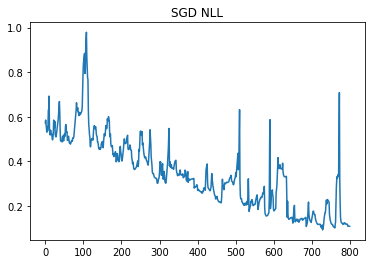

In [444]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, sgd_result['nll'])
ax.set_title('SGD NLL');

Misclassification Rates

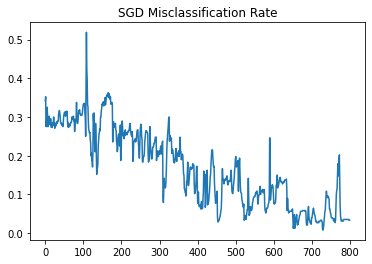

In [445]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, sgd_result['accs'])
ax.set_title('SGD Misclassification Rate');

## 5.5.3 Training Process Visualization

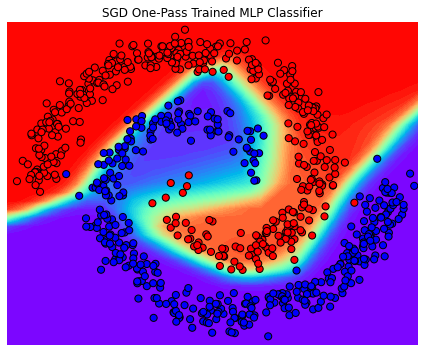

In [446]:
sgd_sp_nc = fit_optax(flat_params_nc, sgd_optimizer, X_train, y_train, loss_fn_nc, num_epochs=1)

# Evaluate the trained MLP on grid and plot
Z_sgd_sp_nc = posterior_predictive_grid(input_grid_nc, sgd_sp_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_train, y_train, title, input_grid_nc, Z_sgd_sp_nc);
fig.savefig('hm_sgd_sp.jpg', bbox_inches = 'tight')

## 5.6 SGD - Multi Pass (20 Epochs)

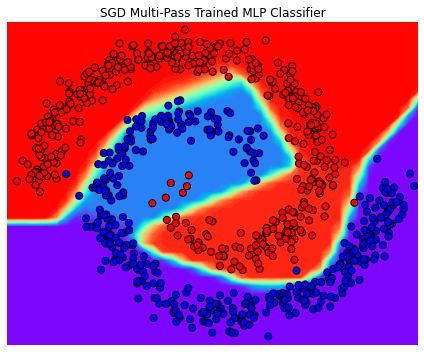

In [449]:
sgd_mp_nc = fit_optax(flat_params_nc, sgd_optimizer, X_train, y_train, loss_fn_nc, num_epochs=20)

# Evaluate the trained MLP on grid and plot
Z_sgd_mp_nc = posterior_predictive_grid(input_grid_nc, sgd_mp_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD Multi-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_train, y_train, title, input_grid_nc, Z_sgd_mp_nc);
fig.savefig('hm_sgd_mp.jpg', bbox_inches = 'tight')

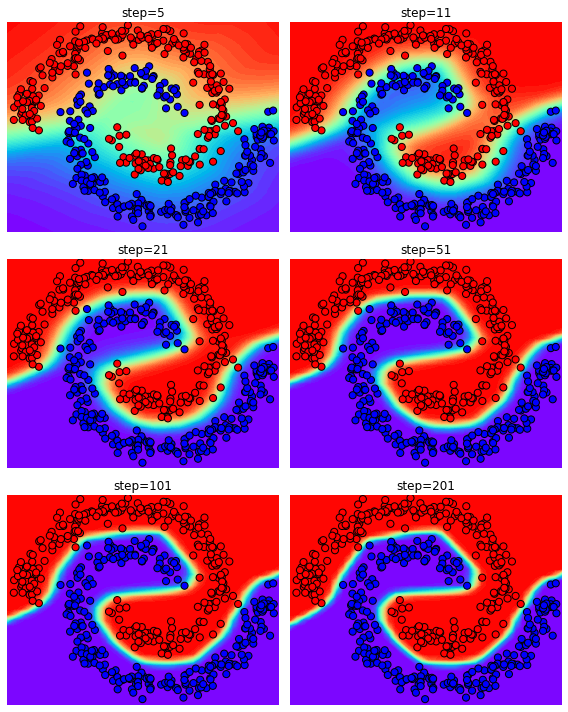

In [92]:
epoch_range = jnp.array([4, 10, 20, 50, 100, 200])
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(epoch_range, ax.flatten()):
    params_step = fit_optax(flat_params_nc, sgd_optimizer, X_nc, Y_nc, loss_fn_nc, num_epochs=step)
    Zi = posterior_predictive_grid(input_grid_nc, params_step, sigmoid_fn_nc, binary=False)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, X_nc, Y_nc, title, input_grid_nc, Zi)
plt.tight_layout()

## 5.7 Model Comparison

## 5.7.1 NLLs and Accuracies

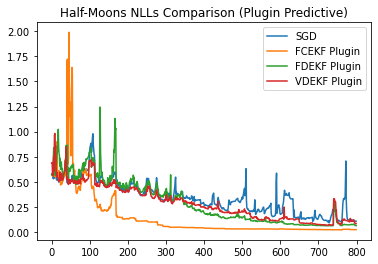

In [452]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, sgd_result['nll'], label='SGD')
ax.plot(train_steps, fcekf_result_map['nll'], label='FCEKF Plugin')
# ax.plot(train_steps, fcekf_result_mc['nll'], label='FCEKF MC')
# ax.plot(train_steps, fcekf_result_immer['nll'], label='FCEKF Linearized')
ax.plot(train_steps, fdekf_result_map['nll'], label='FDEKF Plugin')
# ax.plot(train_steps, fdekf_result_mc['nll'], label='FDEKF MC')
# ax.plot(train_steps, fdekf_result_immer['nll'], label='FDEKF Linearized')
ax.plot(train_steps, vdekf_result_map['nll'], label='VDEKF Plugin')
# ax.plot(train_steps, vdekf_result_mc['nll'], label='VDEKF MC')
# ax.plot(train_steps, vdekf_result_immer['nll'], label='VDEKF Linearized')
ax.legend()
ax.set_title('Half-Moons NLLs Comparison (Plugin Predictive)');
fig.savefig('halfmoons_nll_plugin.png', bbox_inches = 'tight')

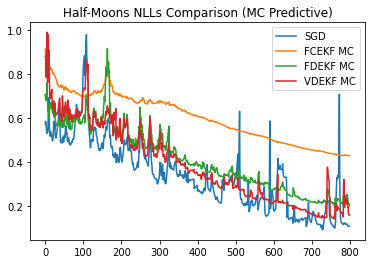

In [453]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, sgd_result['nll'], label='SGD')
# ax.plot(train_steps, fcekf_result_map['nll'], label='FCEKF Plugin')
ax.plot(train_steps, fcekf_result_mc['nll'], label='FCEKF MC')
# ax.plot(train_steps, fcekf_result_immer['nll'], label='FCEKF Linearized')
# ax.plot(train_steps, fdekf_result_map['nll'], label='FDEKF Plugin')
ax.plot(train_steps, fdekf_result_mc['nll'], label='FDEKF MC')
# ax.plot(train_steps, fdekf_result_immer['nll'], label='FDEKF Linearized')
# ax.plot(train_steps, vdekf_result_map['nll'], label='VDEKF Plugin')
ax.plot(train_steps, vdekf_result_mc['nll'], label='VDEKF MC')
# ax.plot(train_steps, vdekf_result_immer['nll'], label='VDEKF Linearized')
ax.legend()
ax.set_title('Half-Moons NLLs Comparison (MC Predictive)');
fig.savefig('halfmoons_nll_mc.png', bbox_inches = 'tight')

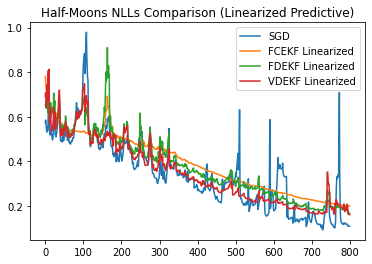

In [454]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, sgd_result['nll'], label='SGD')
# ax.plot(train_steps, fcekf_result_map['nll'], label='FCEKF Plugin')
# ax.plot(train_steps, fcekf_result_mc['nll'], label='FCEKF MC')
ax.plot(train_steps, fcekf_result_immer['nll'], label='FCEKF Linearized')
# ax.plot(train_steps, fdekf_result_map['nll'], label='FDEKF Plugin')
# ax.plot(train_steps, fdekf_result_mc['nll'], label='FDEKF MC')
ax.plot(train_steps, fdekf_result_immer['nll'], label='FDEKF Linearized')
# ax.plot(train_steps, vdekf_result_map['nll'], label='VDEKF Plugin')
# ax.plot(train_steps, vdekf_result_mc['nll'], label='VDEKF MC')
ax.plot(train_steps, vdekf_result_immer['nll'], label='VDEKF Linearized')
ax.legend()
ax.set_title('Half-Moons NLLs Comparison (Linearized Predictive)');
fig.savefig('halfmoons_nll_immer.png', bbox_inches = 'tight')

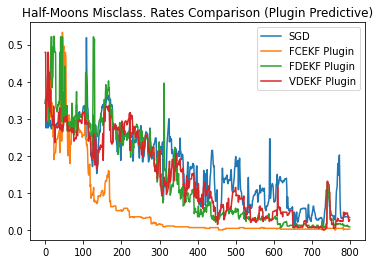

In [455]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, sgd_result['accs'], label='SGD')
ax.plot(train_steps, fcekf_result_map['accs'], label='FCEKF Plugin')
# ax.plot(train_steps, fcekf_result_mc['accs'], label='FCEKF MC')
# ax.plot(train_steps, fcekf_result_immer['accs'], label='FCEKF Linearized')
ax.plot(train_steps, fdekf_result_map['accs'], label='FDEKF Plugin')
# ax.plot(train_steps, fdekf_result_mc['accs'], label='FDEKF MC')
# ax.plot(train_steps, fdekf_result_immer['accs'], label='FDEKF Linearized')
ax.plot(train_steps, vdekf_result_map['accs'], label='VDEKF Plugin')
# ax.plot(train_steps, vdekf_result_mc['accs'], label='VDEKF MC')
# ax.plot(train_steps, vdekf_result_immer['accs'], label='VDEKF Linearized')
ax.legend()
ax.set_title('Half-Moons Misclass. Rates Comparison (Plugin Predictive)');
fig.savefig('halfmoons_accs_plugin.png', bbox_inches = 'tight')

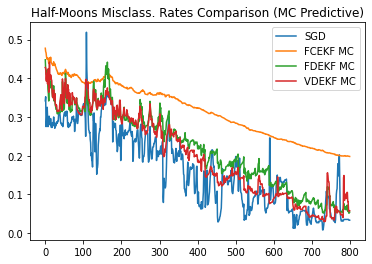

In [456]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, sgd_result['accs'], label='SGD')
# ax.plot(train_steps, fcekf_result_map['accs'], label='FCEKF Plugin')
ax.plot(train_steps, fcekf_result_mc['accs'], label='FCEKF MC')
# ax.plot(train_steps, fcekf_result_immer['accs'], label='FCEKF Linearized')
# ax.plot(train_steps, fdekf_result_map['accs'], label='FDEKF Plugin')
ax.plot(train_steps, fdekf_result_mc['accs'], label='FDEKF MC')
# ax.plot(train_steps, fdekf_result_immer['accs'], label='FDEKF Linearized')
# ax.plot(train_steps, vdekf_result_map['accs'], label='VDEKF Plugin')
ax.plot(train_steps, vdekf_result_mc['accs'], label='VDEKF MC')
# ax.plot(train_steps, vdekf_result_immer['accs'], label='VDEKF Linearized')
ax.legend()
ax.set_title('Half-Moons Misclass. Rates Comparison (MC Predictive)');
fig.savefig('halfmoons_accs_mc.png', bbox_inches = 'tight')

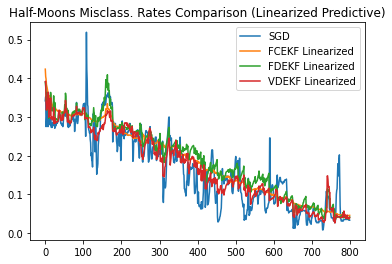

In [457]:
train_steps = jnp.arange(len(X_train))
fig, ax = plt.subplots()
ax.plot(train_steps, sgd_result['accs'], label='SGD')
# ax.plot(train_steps, fcekf_result_map['accs'], label='FCEKF Plugin')
# ax.plot(train_steps, fcekf_result_mc['accs'], label='FCEKF MC')
ax.plot(train_steps, fcekf_result_immer['accs'], label='FCEKF Linearized')
# ax.plot(train_steps, fdekf_result_map['accs'], label='FDEKF Plugin')
# ax.plot(train_steps, fdekf_result_mc['accs'], label='FDEKF MC')
ax.plot(train_steps, fdekf_result_immer['accs'], label='FDEKF Linearized')
# ax.plot(train_steps, vdekf_result_map['accs'], label='VDEKF Plugin')
# ax.plot(train_steps, vdekf_result_mc['accs'], label='VDEKF MC')
ax.plot(train_steps, vdekf_result_immer['accs'], label='VDEKF Linearized')
ax.legend()
ax.set_title('Half-Moons Misclass. Rates Comparison (Linearized Predictive)');
fig.savefig('halfmoons_accs_immer.png', bbox_inches = 'tight')

## 5.7.2 Training Process Visualization

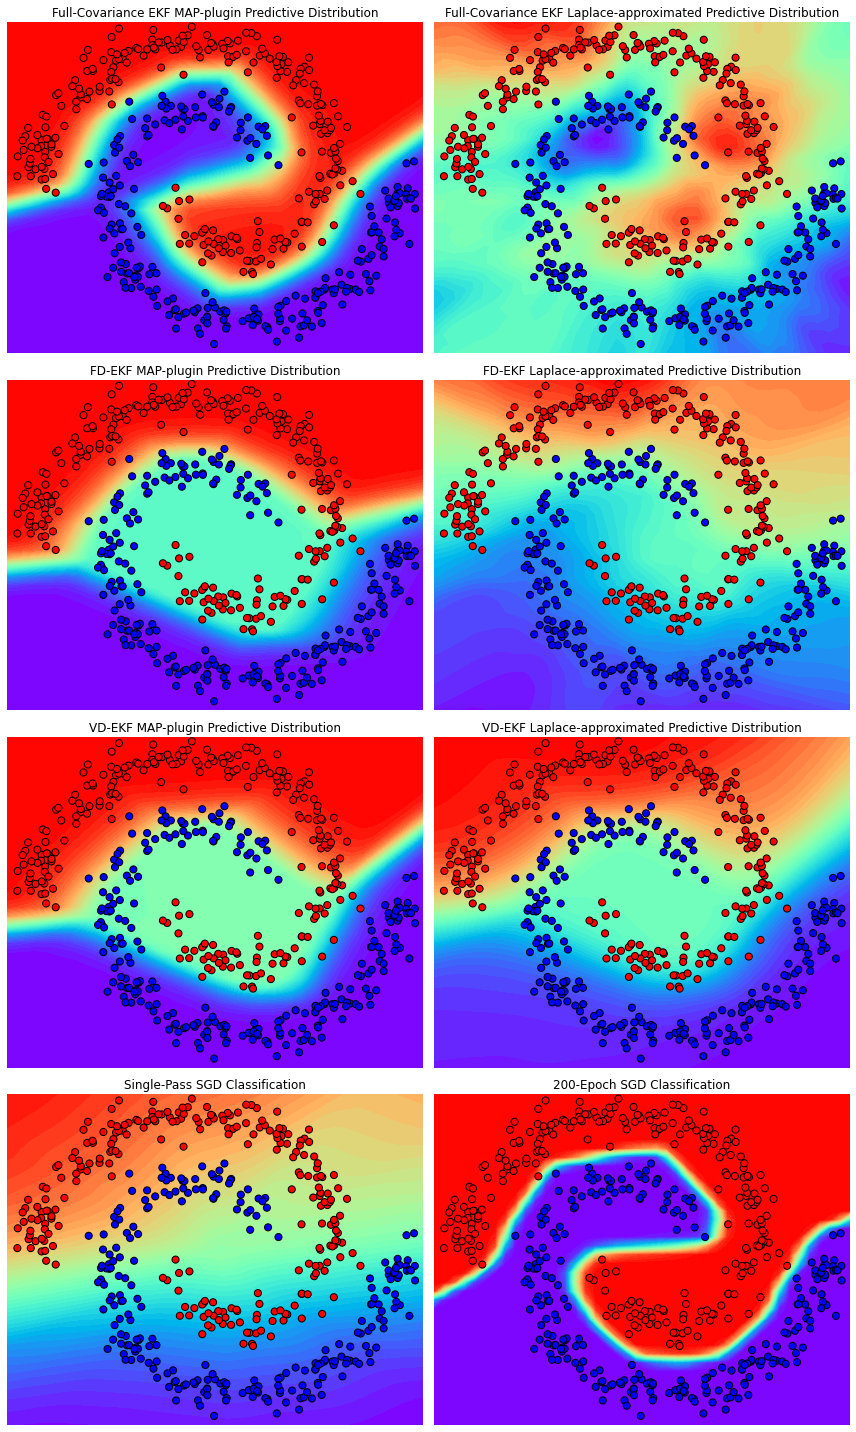

In [93]:
fig, axs = plt.subplots(4, 2, figsize=(12, 20))
title1 = "Full-Covariance EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(axs[0, 0], X_nc, Y_nc, title1, input_grid_nc, Z_fcekf_nc);
title2 = "Full-Covariance EKF Laplace-approximated Predictive Distribution"
plot_posterior_predictive(axs[0, 1], X_nc, Y_nc, title2, input_grid_nc, Z_fcekf_nc_laplace);
title3 = "FD-EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(axs[1, 0], X_nc, Y_nc, title3, input_grid_nc, Z_fdekf_nc);
title4 = "FD-EKF Laplace-approximated Predictive Distribution"
plot_posterior_predictive(axs[1, 1], X_nc, Y_nc, title4, input_grid_nc, Z_fdekf_nc_laplace);
title5 = "VD-EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(axs[2, 0], X_nc, Y_nc, title5, input_grid_nc, Z_vdekf_nc);
title6 = "VD-EKF Laplace-approximated Predictive Distribution"
plot_posterior_predictive(axs[2, 1], X_nc, Y_nc, title6, input_grid_nc, Z_vdekf_nc_laplace);
title7 = "Single-Pass SGD Classification"
plot_posterior_predictive(axs[3, 0], X_nc, Y_nc, title7, input_grid_nc, Z_sgd_sp_nc);
title8 = "200-Epoch SGD Classification"
plot_posterior_predictive(axs[3, 1], X_nc, Y_nc, title8, input_grid_nc, Z_sgd_mp_nc);
fig.savefig('halfmoon_comparison.jpg')